<a href="https://colab.research.google.com/github/zer0Percent/NNLP/blob/Tema1/Sentiment_Analysis_An_analysis_of_ML_and_DL_approaches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Álvaro Domínguez Calvo. <br>

dominguezcalvoalvaro@icloud.com

# 1. Introduction

Sentiment analysis consists in analyzing automatically and detecting the 
sentiment contained in textual information. This task is usually seen as a classification problem within the context of Machine Learning where a properly manually labelled dataset is provided. <br>

The dataset $D$ contains $n$ documents where, given $d \in D$, $d$ is mapped to a class $c_i \in C$. Each $d$ must be mapped to a formal representation. Due to Machine Learning algorithms deal with numerica data, it is mandatory to structure this textual information. Hence a document could be considered as a vector in a $\Re^m$ space where $m$ is the dimension of the vector. In the literature this is known as features and, to obtain the most informative ones, a preprocessing of each word of $d$ must be executed. <br>

In this work it will applied two classical Machine Learning algorithms and a neural network arquitecture to perform the classification. The selected Machine learning algorithms are Support Vector Machine and k-nearest neighbors. First it will be loaded the dataset with a brief exploratory analysis of its content. Secondly, a pipeline is proposed to delete textual information that do not give semantic information in the classification task. After this preprocessing, three types of document representation are proposed under the asumption that a  document is a unordered collection of words, i.e bag of words model. These representations are: Count word vector, TF-IDF vector and word embbedding. The first two will be used in the classical algorithms. The last two in the neural network approaches. <br>

## 1.2 Imports and dependencies

In [6]:
! pip install pandas numpy seaborn torch scikit-learn matplotlib nltk gdown

In [1]:
from argparse import Namespace
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
params = {'legend.fontsize': '16',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':15,
         'ytick.labelsize': 15
}
plt.rcParams.update(params)
from nltk.tokenize import WhitespaceTokenizer

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

# 2. Data exploration

## Data loading

The dataset has been uploaded to a Google Drive folder so it can be used when required.

In [7]:
!gdown https://drive.google.com/uc?id=1dIzUE8sMpUNN5yfoQgKQpbeefHCsiIcY

zsh:1: no matches found: https://drive.google.com/uc?id=1dIzUE8sMpUNN5yfoQgKQpbeefHCsiIcY


In [9]:
import gdown

# a file
url = "https://drive.google.com/uc?id=1dIzUE8sMpUNN5yfoQgKQpbeefHCsiIcY"
output = "/Users/alvarito/Documents/Github/NNLP/Tema1/Dataset_reviews.zip"
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1dIzUE8sMpUNN5yfoQgKQpbeefHCsiIcY
To: /Users/alvarito/Documents/Github/NNLP/Tema1/Dataset_reviews.zip
100%|██████████| 5.46M/5.46M [00:00<00:00, 23.5MB/s]


'/Users/alvarito/Documents/Github/NNLP/Tema1/Dataset_reviews.zip'

In [10]:
!unzip -q /Users/alvarito/Documents/Github/NNLP/Tema1/Dataset_reviews.zip

This will unzip the dataset. We will store it in a DataFrame object and visualice the first twenty rows. First, we need to parse the csv files in order to build their corresponding DataFrame.

In [2]:
training_set = pd.read_csv("./Dataset_reviews/train_reviews.csv", quotechar='"', header=0, sep=",")
test_set = pd.read_csv("./Dataset_reviews/test_reviews.csv", quotechar='"', header=0, sep=",")

In [12]:
training_set.head(20)

,id,review,sentiment
0,17527,People tried to make me believe that the premi...,negative
1,24155,I have been wanting to see cut since the day i...,positive
2,21972,This movie is terrible. The suspense is spent ...,negative
3,4565,I hope she can keep acting and directing. She'...,positive
4,22098,I fell in love with this silent action drama. ...,positive
5,5138,Shame Shame Shame on UA/DW for what you do! <b...,negative
6,16932,It's not very often a movie can literally make...,positive
7,13181,I was very interested to see this movie when i...,positive
8,3299,It might not be the best movie of 2006 but it ...,positive
9,18982,I went to see the Omega Code with a group of o...,negative


We will check that every instance has a gold value in order to ensure that our dataset has no missing values. We will get empty dataframes indicating that our dataset is correctly labeled.

In [ ]:
labels = {"positive", "negative"}
train_instances_problem = training_set[training_set.sentiment.isin(labels) == False]
train_instances_problem

,id,review,sentiment


In [ ]:
test_instances_problem = test_set[test_set.sentiment.isin(labels) == False]
test_instances_problem

,id,review,sentiment


We need to check if our dataset is balanced in terms of the number of instances for each class.

For the training set

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

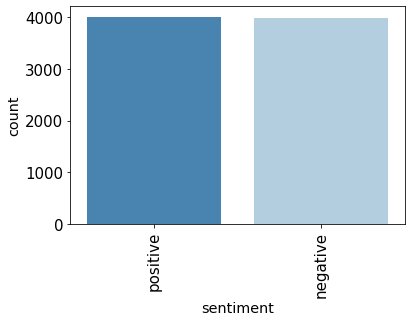

In [ ]:
from collections import Counter
sns.countplot(training_set.sentiment, order=[x for x, count in sorted(Counter(training_set.sentiment).items(), key=lambda x: -x[1])], palette="Blues_r")
plt.xticks(rotation=90)

For the test set

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

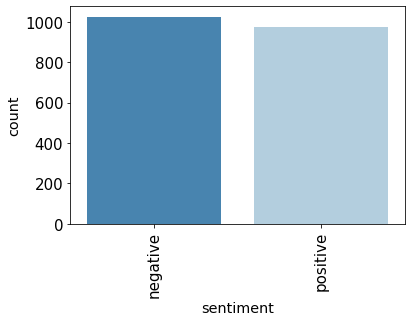

In [ ]:
sns.countplot(test_set.sentiment, order=[x for x, count in sorted(Counter(test_set.sentiment).items(), key=lambda x: -x[1])], palette="Blues_r")
plt.xticks(rotation=90)

We see that for the test set, the dataset is sightly unbalanced but not that much.

### Analysing raw reviews

It is trivial that we need to preprocess de data but we need to wonder why that processing is needed and, in terms of the results of this analysis, build data processors that will curate the data we will use for the training, validation and testing models.

This analysis is driven in a frequestist approach and we will see how our raw dataset looks like. For this purpose

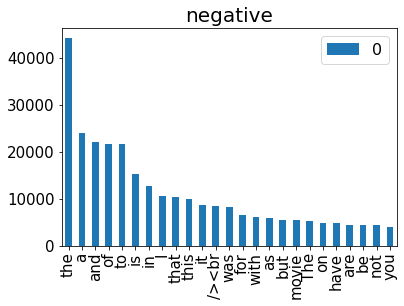

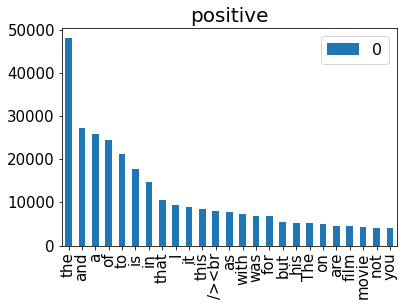

In [ ]:
from matplotlib import interactive

df = pd.DataFrame({"review": training_set.review, "CLASS": training_set.sentiment})
grouped = df.groupby(["CLASS"]).apply(lambda x: x["review"].sum())
grouped_df = pd.DataFrame({"CLASS": grouped.index, "review": grouped.values})

from nltk.tokenize import WhitespaceTokenizer
tokenizer = WhitespaceTokenizer()

for ii, review in enumerate(grouped_df.review):
    pd.DataFrame(tokenizer.tokenize(review)).apply(pd.value_counts).head(25).plot(kind="bar")
    plt.title(grouped_df.CLASS[ii], fontsize=20)
    plt.xticks(fontsize=15)
    interactive(True)
    plt.show()

The two later histograms show similar distributions in terms of the tokens that have been counted. Besides there are tokens like $The$ and $the$ that: (1) Refer to the same linguistic concept. In this case an article; (2) It does not contribute meaningful information when determining the sentiment of a review.Indeed, there are HTML tags (< br>) that are not relevant. Thus a preprocessing pipeline is needed in order to filter those tokens that give valuable semantic information.

### Pipeline for data processing

The pipeline for processing the reviews is depicted in the image below
![picture](https://docs.google.com/uc?id=1R9HFHcLKQobCB-xCwSbSSOqg2KbFAjFI)

The modules for stemming and lemmatize words are optional. In special, the stemmize one because it will not be useful when generating the word embedding matrix since the pretrained word embeddings are not stemmed. All the HTML tags, numbers, and english stop words are deleted. All the words have been lowercased. The tokenizer simply splits a sentence by the white space and, when a document is processed, it is again represented in one string (`untokenize` module). <br>


The `process` functions takes a raw text and clean up each of its tokens regarding the this pipeline.

In [ ]:
tokenizer = WhitespaceTokenizer()

In [3]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import re

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stemmizer = PorterStemmer()
def process(raw_text, stem=True, lemmatize=True):

  processed = []
  # letters
  # we delete anything enclosed between < >
  no_html_tags = re.sub(r'<[^>]+>', " ", raw_text)
  letters_only = re.sub("[^a-zA-Z]", " ", no_html_tags)

  #lower
  words = letters_only.lower().split()

  #stopwords
  stops = set(stopwords.words("english"))
  no_stop_words = [word for word in words if not word in stops]

  processed = no_stop_words
  if lemmatize:
    #lemmatize
    processed = [lemmatizer.lemmatize(word) for word in processed]

  if stem:
    #stemize
    processed = [stemmizer.stem(word) for word in processed]

  #untokenize
  return (" ".join(processed))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alvarito/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alvarito/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
process("Aldo said that you were using that car. You got this Volvo and everything is good :-)")

'aldo said use car got volvo everyth good'

If we apply  the `process` function to the column `review` of the dataset we get the following DataFrame. All the dataset must be processed equally so the `train` and `test` set must be merged.

In [4]:
dataset = pd.concat([training_set,test_set])
dataset['processed_review'] = dataset['review'].apply(lambda x: process(x))
dataset['review_no_stem'] = dataset['review'].apply(lambda x: process(x, stem=False))
dataset.head()

,id,review,sentiment,processed_review,review_no_stem
0,17527,People tried to make me believe that the premi...,negative,peopl tri make believ premis rubbishi supernat...,people tried make believe premise rubbishy sup...
1,24155,I have been wanting to see cut since the day i...,positive,want see cut sinc day heard sometim last year ...,wanting see cut since day heard sometime last ...
2,21972,This movie is terrible. The suspense is spent ...,negative,movi terribl suspens spent wait point much one...,movie terrible suspense spent waiting point mu...
3,4565,I hope she can keep acting and directing. She'...,positive,hope keep act direct sure task could easili de...,hope keep acting directing surely task could e...
4,22098,I fell in love with this silent action drama. ...,positive,fell love silent action drama kurt russel kurt...,fell love silent action drama kurt russell kur...


We split up again the dataset keeping in mind that must be done in a stratified fashion of the `sentiment` label. This is needed because it must be ensured that the new splitting is balanced in function of the class label.

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, stratify=dataset['sentiment'], test_size=0.2)
y_train = train['sentiment']
y_test = test['sentiment']

We plot again the distribution of term counts.

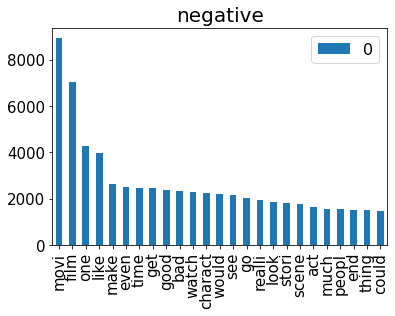

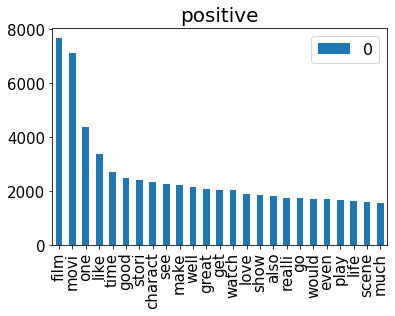

In [ ]:

df = pd.DataFrame({"review": dataset[0:len(training_set)].processed_review, "CLASS": dataset[0:len(training_set)].sentiment})
grouped = df.groupby(["CLASS"]).apply(lambda x: x["review"].sum())
grouped_df = pd.DataFrame({"CLASS": grouped.index, "review": grouped.values})

from nltk.tokenize import WhitespaceTokenizer
tokenizer = WhitespaceTokenizer()

for ii, review in enumerate(grouped_df.review):
    pd.DataFrame(tokenizer.tokenize(review)).apply(pd.value_counts).head(25).plot(kind="bar")
    plt.title(grouped_df.CLASS[ii], fontsize=20)
    plt.xticks(fontsize=15)
    interactive(True)
    plt.show()

# 3. Data representation: word count and TF-IDF

## TF-IDF matrix

From the `training_set` it is easy to obtain the TF-IDF matrix, which is defined as follows: <br/> Given a set of terms $V$ (vocabulary) obtained from the preprocessing pipeline such that $|V| = m$ and supossing that a review $r$ is represented with the terms of $V$, then $r$ is a vector such that $\vec{r} \in \Re^m$. Let $D_{train}$ the training set of length $|D_{train}|= n$, the TF-IDF matrix is defined as $\boldsymbol{M} \in \Re^{n \times m}$. <br>
An element  $a_{i, \: j} \in \boldsymbol{M}$ is defined as: <br> <br>
> $a_{i, \: j} = tf\_idf(t, \: d) = tf(t, d) \times idf(t)$ <br> <br>

where $tf(t, d)$ is the number of times the term $t$ appears in the document $d$ and $idf(t)$ is the inverse document frequency. That is, the inverse of the number of documents that $t$ appears within the $D_{train}$ subset. <br>

In this case the $idf$ value is defined as: <br> <br>
> $idf(t)$ = $log(\frac{1+n}{1+df(t)})+1$

where $df(t)$ is the number of documents where the term $t$ appears and $n = |D_{train}|$.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=5)
train_tf_idf = vectorizer.fit_transform(train['processed_review'])
test_tf_idf = vectorizer.transform(test['processed_review'])
print(train_tf_idf.shape)
print(test_tf_idf.shape)

(8000, 10506)
(2000, 10506)


Next, the gold labels will be encoded in order to avoid using textual information when training and evaluating models.

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(y_train.values)
target_labels = le.classes_
encoded_y_train = le.transform(y_train.values)
encoded_y_test = le.transform(y_test.values)

## Word count representation

This representation consists in counting the frequency of a term within the document. As the TF-IDF approach, it represents a document with a vector $\vec{r} \in ℕ ^ m$ where $m$ is the size of the vocabulary $V$.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(analyzer = "word")

train_count = count_vect.fit_transform(train['processed_review'])
test_count = count_vect.transform(test['processed_review'])

# 4. Training and evaluating classifiers

Based on the representation of a review, that is, TF-IDF vector or word embedding, it will be trained some classificator models so as to compare the performance with the neural network one.

When training a model it is common to train different ones by varying some of their parameters in order to obtain the best model that would be obtained by trying a set of values of these parameters. It will be used the grid search strategy to accomplish this goal. <br>

 

The main metric evaluation that will be considered is the accuracy. The accuracy is defined as follows: <br>

Assuming the binary classification task. Let the confusion matrix $C$ so that contains $TP$ true positives, and $FP$ false positives. The accuracy is given by<br>

$accuracy = \frac{TP}{TP + TN}$

## 4.1 Training with TF-IDF and count words review representation

### Handy functions <br>
The following functions will help when training and evaluating models by representing train and validation plots, training classical classifiers and plotting the confusion matrix.

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

In [ ]:
def train_and_evaluate_classifier(X, yt, estimator, grid):
    """Train and Evaluate a estimator (defined as input parameter) on the given labeled data using accuracy."""
    
    # Se realiza validación cruzada sobre el clasificador seleccionado
    from sklearn.model_selection import ShuffleSplit
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
      
    from sklearn.model_selection import GridSearchCV
    classifier = GridSearchCV(estimator=estimator, cv=cv,  param_grid=grid, error_score=0.0, n_jobs = -1, verbose = 5)
    
    # Entrenamiento
    print("Training model")
    classifier.fit(X, yt)

    # Puntuación de la validación cruzada
    from sklearn.model_selection import cross_val_score
    print("CV-scores for each grid configuration")
    means = classifier.cv_results_['mean_test_score']
    stds = classifier.cv_results_['std_test_score']
    for mean, std, params in sorted(zip(means, stds, classifier.cv_results_['params']), key=lambda x: -x[0]):
        print("Accuracy: %0.3f (+/-%0.03f) for params: %r" % (mean, std * 2, params))
    print()
        
    # Curva de aprendizaje
    print("Learning curve for the best estimator")
    title = 'Learning Curves (' + str(estimator.__class__).replace("'>", "").split(".")[-1] + ' )'
    plot_learning_curve(classifier.best_estimator_, title, X, yt, cv=cv)
    plt.show()
    
    return classifier

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## 4.2 Classic Machine Learning algorithms

The two classical machine learning algorithms chosen are Support Vector Machines and k-nearest neighbors. For each review vector representation (TF-IDF and count of words) it will be trained these two algorithms.  I.e: <br>
* SVM with TF-IDF representation
* SVM with count word representation
* k-nn with TF-IDF representation
* k-nn with count word representation

The search of the best model given an algorithm is execued with a grid search approach. The grid search consists in train and validate classifiers by generating combinations of a fixed set of hyperparameters and persisting the best model amongst all of the trained ones. This is reflected in the `train_and_evaluate_classifier` function.

### SVM

A Support Vector Machine is a algorithm that looks for an hyperplane $π$ that separates a set of points $D = \{p_1, \; p_2, \; ..., \;p_n\}$ where $p_i$ is a vector in a $d-$dimensional space. The following image describes the result of a learned SVM. <br>
![picture](https://docs.google.com/uc?id=1N-8wkwUsob7CY24PLebxWtWcv7WDZ3nC)

The learned hyperplane $ π \equiv w· x + b = 0$ can be used to classify new data points. The case of the image separates the data points linearly by employing a lineal kernel function. However, it is probably that the datapoints are not linearly separable so different kernel functions must be used in order to achieve that separation. Kernel functions allow to execute the so-called kernel trick, that is, it executes a mapping towards higher dimensions so that the dataset is separable.
<br>
The experiments have consisted in varying the following parameters: <br>
* `C`: Governs the influence of the misclassification on the kernel function.
* `kernel`: Determines the kernel function used in the training process.

## Training with TF-IDF matrix

First, we define the hyperparameters for the grid search and then call the `train_and_evaluate_classifier` function.

Training model
Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed: 20.2min finished


CV-scores for each grid configuration
Accuracy: 0.864 (+/-0.022) for params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.864 (+/-0.022) for params: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy: 0.863 (+/-0.024) for params: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.863 (+/-0.023) for params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy: 0.853 (+/-0.023) for params: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy: 0.853 (+/-0.025) for params: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy: 0.839 (+/-0.025) for params: {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy: 0.838 (+/-0.020) for params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.838 (+/-0.024) for params: {'C': 100, 'kernel': 'linear'}
Accuracy: 0.838 (+/-0.024) for params: {'C': 1000, 'kernel': 'linear'}
Accuracy: 0.698 (+/-0.211) for params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.697 (+/-0.211) for params: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy: 0.492 (+/-

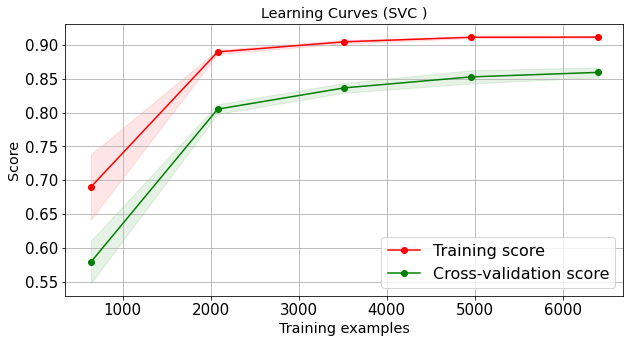

In [ ]:
from sklearn.svm import SVC

svm_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01], 'kernel': ['rbf']}
 ]

svm_cls = train_and_evaluate_classifier(train_tf_idf, encoded_y_train, SVC(), svm_grid)

The results over the test set are shown below

In [ ]:
print("Predicting new instances")
y_pred = svm_cls.predict(test_tf_idf)

y_pred = le.inverse_transform(y_pred)

Predicting new instances


Classification Report
              precision    recall  f1-score   support

    positive       0.90      0.83      0.86      1003
    negative       0.84      0.90      0.87       997

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000

Confusion matrix, without normalization


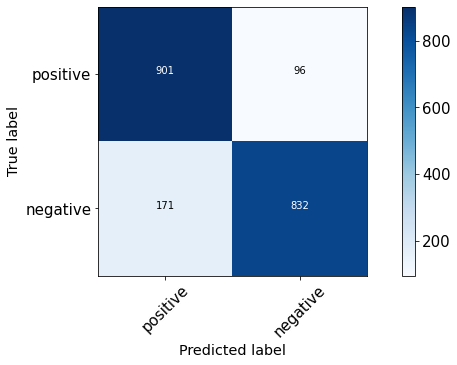

Final Accuracy
0.8665


In [ ]:
print("Classification Report")
print
print(classification_report(y_test, y_pred, target_names=["positive", "negative"]))
cm = confusion_matrix(y_test, y_pred, labels=["positive", "negative"])
 
plot_confusion_matrix(cm, classes=["positive", "negative"])

print("Final Accuracy")
print(accuracy_score(y_test, y_pred,))

## Training with word count matrix

Training model
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.8min finished


CV-scores for each grid configuration
Accuracy: 0.863 (+/-0.012) for params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.860 (+/-0.010) for params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.840 (+/-0.010) for params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.834 (+/-0.012) for params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.834 (+/-0.012) for params: {'C': 100, 'kernel': 'linear'}
Accuracy: 0.833 (+/-0.010) for params: {'C': 1, 'kernel': 'linear'}

Learning curve for the best estimator


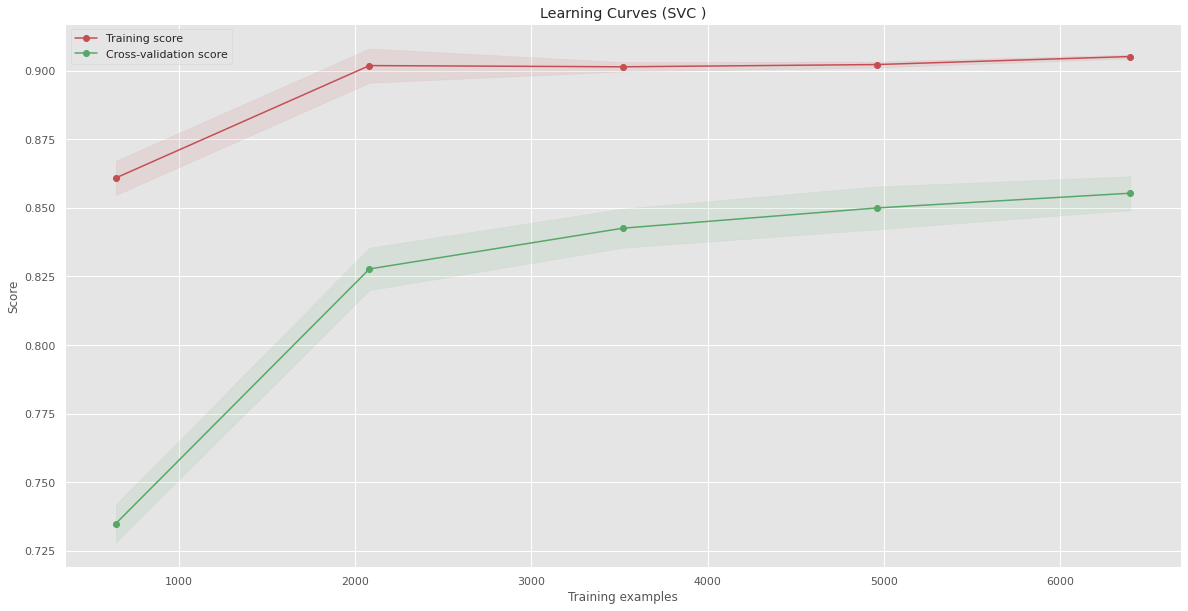

In [ ]:
svm_grid = [
  {'C': [1, 10, 100], 'kernel': ['linear']},
  {'C': [10, 100, 1000], 'gamma': [0.0001], 'kernel': ['rbf']}
 ]

svm_count = train_and_evaluate_classifier(train_count, encoded_y_train, SVC(), svm_grid)

The results over the test set are shown below

In [ ]:
print("Predicting new instances")
y_pred_count = svm_count.predict(test_count)

y_pred_count = le.inverse_transform(y_pred_count)

Predicting fake news on the test set


Classification Report
              precision    recall  f1-score   support

    positive       0.89      0.82      0.85      1003
    negative       0.83      0.89      0.86       997

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000

Confusion matrix, without normalization


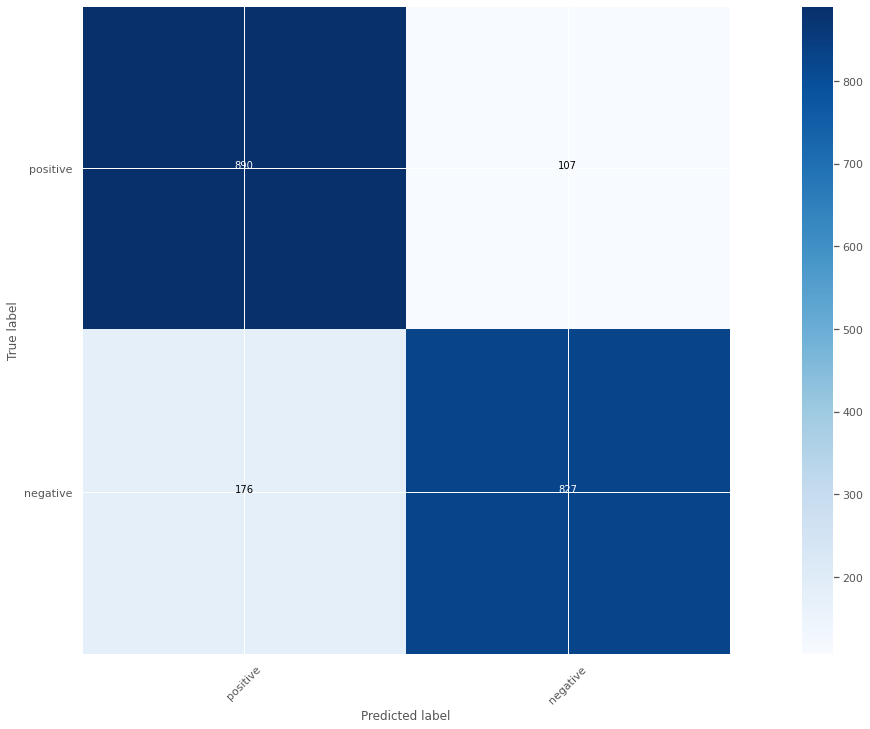

Final Accuracy
0.8585


In [ ]:
print("Classification Report")
print
print(classification_report(y_test, y_pred_count, target_names=["positive", "negative"]))
cm = confusion_matrix(y_test, y_pred_count, labels=["positive", "negative"])
 
plot_confusion_matrix(cm, classes=["positive", "negative"])

print("Final Accuracy")
print(accuracy_score(y_test, y_pred_count,))

## *k*-nn algorithm

The k nearest neighbors method is a lazy learning algorithm that looks for vector which represent the most informative object of a class $c_i \in C$ where $C$ is a set of classes. The two key parameters of this algorithm are: <br>
*  The value of $k$ which determines how many instances are considered to be within a class during the training step.
* The distance definition which is determined by the Minkowski distance. In the implementation this is reflected in the `p` parameter.

In this context, the training process consists in determine the centroid (vector) of each class which will be used to classify new instances.

### Training with TF-IDF matrix

Training model
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.1min finished


CV-scores for each grid configuration
Accuracy: 0.760 (+/-0.022) for params: {'n_neighbors': 13, 'p': 2}
Accuracy: 0.748 (+/-0.025) for params: {'n_neighbors': 8, 'p': 2}
Accuracy: 0.739 (+/-0.011) for params: {'n_neighbors': 5, 'p': 2}
Accuracy: 0.730 (+/-0.014) for params: {'n_neighbors': 3, 'p': 2}
Accuracy: 0.563 (+/-0.032) for params: {'n_neighbors': 13, 'p': 1}
Accuracy: 0.544 (+/-0.030) for params: {'n_neighbors': 5, 'p': 1}
Accuracy: 0.530 (+/-0.041) for params: {'n_neighbors': 8, 'p': 1}
Accuracy: 0.509 (+/-0.012) for params: {'n_neighbors': 3, 'p': 1}

Learning curve for the best estimator


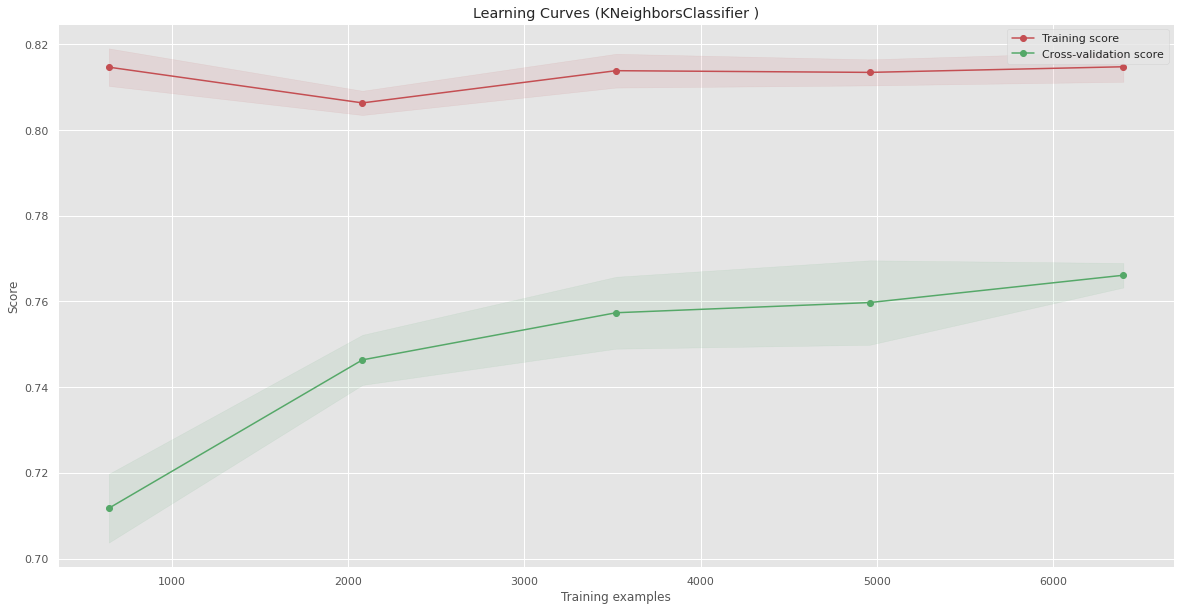

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_grid = [
{
  'n_neighbors' : [3, 5, 8, 13],
  'p': [1, 2]   
}]
knn_tf_idf = train_and_evaluate_classifier(train_tf_idf, encoded_y_train,
                                           KNeighborsClassifier(), knn_grid)


In [ ]:
print("Predicting new instances")
y_pred_knn_tf_idf = knn_tf_idf.predict(test_tf_idf)

y_pred_knn_tf_idf = le.inverse_transform(y_pred_knn_tf_idf)

Predicting fake news on the test set


Classification Report
              precision    recall  f1-score   support

    positive       0.80      0.71      0.76      1003
    negative       0.74      0.83      0.78       997

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000

Confusion matrix, without normalization


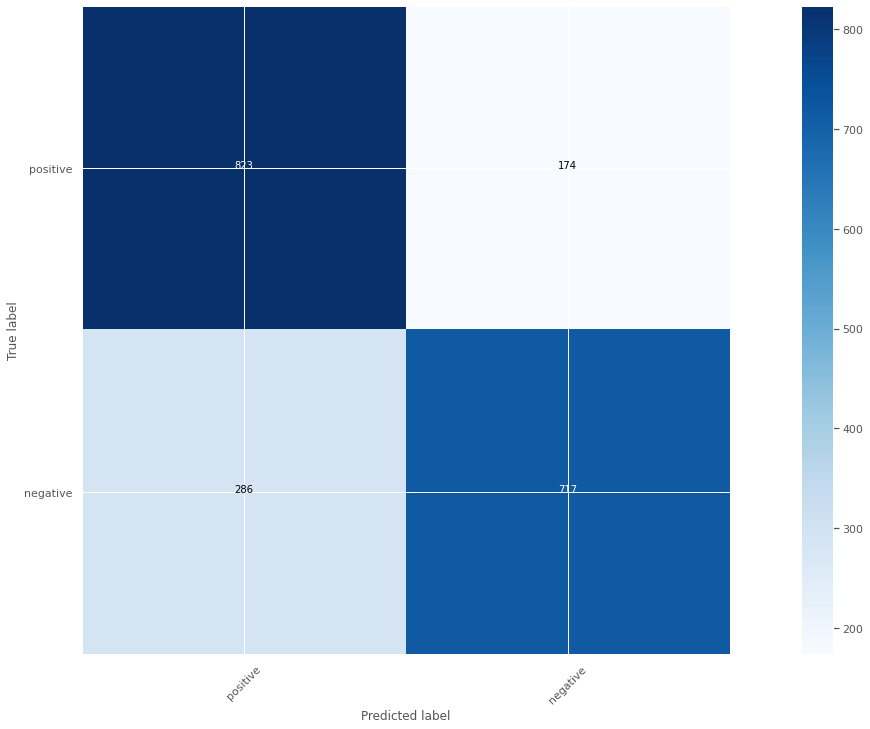

Final Accuracy
0.77


In [ ]:
print("Classification Report")
print
print(classification_report(y_test, y_pred_knn_tf_idf, target_names=["positive", "negative"]))
cm = confusion_matrix(y_test, y_pred_knn_tf_idf, labels=["positive", "negative"])
 
plot_confusion_matrix(cm, classes=["positive", "negative"])

print("Final Accuracy")
print(accuracy_score(y_test, y_pred_knn_tf_idf,))

### Training with word count matrix

Training model
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.3min finished


CV-scores for each grid configuration
Accuracy: 0.663 (+/-0.032) for params: {'n_neighbors': 13, 'p': 2}
Accuracy: 0.660 (+/-0.032) for params: {'n_neighbors': 13, 'p': 1}
Accuracy: 0.624 (+/-0.020) for params: {'n_neighbors': 8, 'p': 2}
Accuracy: 0.623 (+/-0.018) for params: {'n_neighbors': 5, 'p': 2}
Accuracy: 0.609 (+/-0.016) for params: {'n_neighbors': 3, 'p': 2}
Accuracy: 0.583 (+/-0.021) for params: {'n_neighbors': 5, 'p': 1}
Accuracy: 0.581 (+/-0.042) for params: {'n_neighbors': 8, 'p': 1}
Accuracy: 0.552 (+/-0.022) for params: {'n_neighbors': 3, 'p': 1}

Learning curve for the best estimator


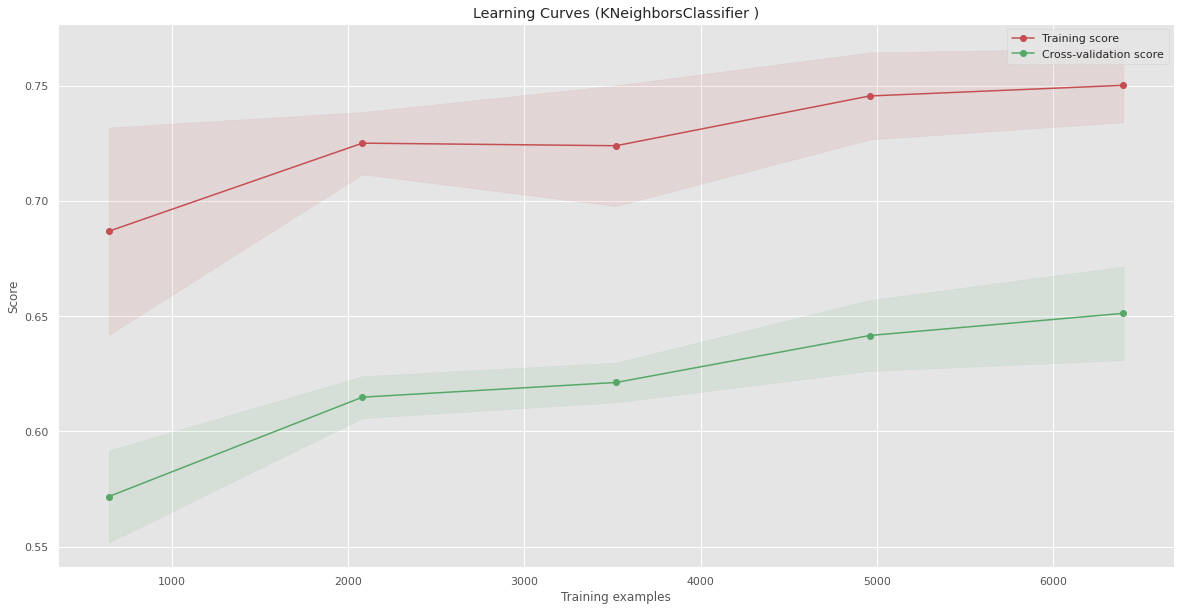

In [ ]:
knn_grid = [
{
  'n_neighbors' : [3, 5, 8, 13],
  'p': [1, 2]   
}]
knn_count = train_and_evaluate_classifier(train_count, encoded_y_train,
                                           KNeighborsClassifier(), knn_grid)

In [ ]:
print("Predicting fake news on the test set")
y_pred_knn_count = knn_count.predict(test_count)

# Se deshace la transformación de las predicciones para obtener las predicciones como REAL o FAKE
y_pred_knn_count = le.inverse_transform(y_pred_knn_count)

Predicting fake news on the test set


Classification Report
              precision    recall  f1-score   support

    positive       0.64      0.75      0.69      1003
    negative       0.70      0.58      0.63       997

    accuracy                           0.66      2000
   macro avg       0.67      0.66      0.66      2000
weighted avg       0.67      0.66      0.66      2000

Confusion matrix, without normalization


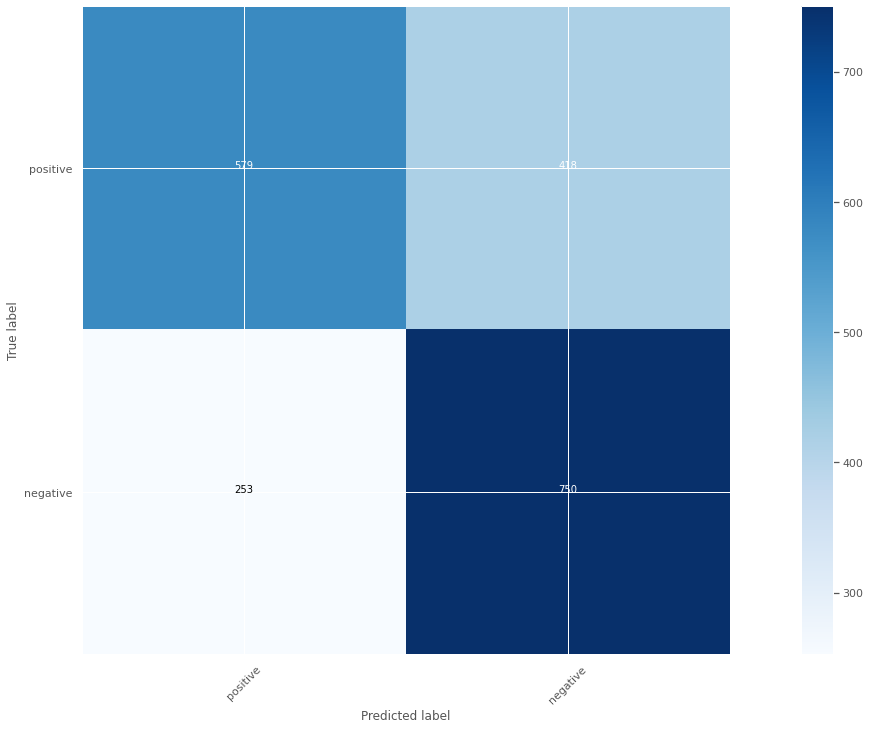

Final Accuracy
0.6645


In [ ]:
print("Classification Report")
print
print(classification_report(y_test, y_pred_knn_count, target_names=["positive", "negative"]))
cm = confusion_matrix(y_test, y_pred_knn_count, labels=["positive", "negative"])
 
plot_confusion_matrix(cm, classes=["positive", "negative"])

print("Final Accuracy")
print(accuracy_score(y_test, y_pred_knn_count,))

## 4.2 Neural network approaches

For the neural network approach, it will be used PyTorch as the framework to build the net. PyTorch allows to reutilize some useful classes to build the dataset and the neural network architecture. <br>
Building the dataset with the provided class by Pytorch allow to store the data itself and the potential representation for each instance of the dataset. <br>


First, the `dataset` DataFrame will be modified to persist the splitting of the dataset. For this, it is needed to define the proportion of the evaluation and test size given the entire dataset. <br>
It will be splitted two times in order to get the `train`, `eval` and `test` subsets but keeping in mind that is mandatory to perform this sampling in a stratified fashion approach.

In [6]:
# defining all the parameters needed for training and evaluating neural network classifiers
vectorizers = Namespace(
    tfidf = 'tfidf',
    embedder = 'embedder'
)

args = Namespace(
    eval_proportion=0.2,
    test_proportion=0.2,
    epochs=30,
    batch_size=128,
    early_stopping_criteria=3,
    learning_rate = 0.001,
    cutoff=5,
    device='metal',
    cuda=True,
    model_state_file='model.pth',
    save_dir='./model/',
    embedding_size=300,
    max_len_review = 120,
    path_embeddings='glove.6B.300d.txt',
    vectorizer_type = 'tfidf'
)

This function splits the entire dataset in `train`, `eval` and `test` subsets.

In [7]:
def split_train_eval_test(dataset_df, eval_size, test_size):

  #e.g: 80% train, 20% test
  train, test = train_test_split(dataset, stratify=dataset_df['sentiment'], test_size=test_size, random_state=1)
  #e.g: From the later 80% of train 60% train, 20% eval
  X_train, X_eval = train_test_split(train, stratify=train['sentiment'], test_size=eval_size, random_state=1)

  return X_train, X_eval, test



In [8]:
train_nn, eval_nn, test_nn = split_train_eval_test(dataset_df=dataset,
                                                   eval_size=args.eval_proportion,
                                                   test_size=0.2)
print('Train: {}, Eval: {} Test: {}'.format(train_nn.shape, eval_nn.shape, test_nn.shape))

Train: (6400, 5), Eval: (1600, 5) Test: (2000, 5)


For each subset, it will be included a new column `split` to denote to which subset belongs each instance. Once this is done, the three subsets will be merged.

In [9]:
train_nn['split'] = ['train' for _ in range(0, train_nn.shape[0])]
eval_nn['split'] = ['eval' for _ in range(0, eval_nn.shape[0])]
test_nn['split'] = ['test' for _ in range(0, test_nn.shape[0])]

In [27]:
dataset_splitted = pd.concat([train_nn, eval_nn, test_nn])
dataset_splitted.head()

,id,review,sentiment,processed_review,review_no_stem,split
5237,14297,"but ""Cinderella"" gets my vote, not only for th...",negative,cinderella get vote worst disney princess movi...,cinderella get vote worst disney princess movi...,train
281,715,I once promised never to walk out of any film ...,negative,promis never walk film person polici made suff...,promised never walk film personal policy made ...,train
392,1943,This is a rip-roaring British comedy movie and...,positive,rip roar british comedi movi one could watch w...,rip roaring british comedy movie one could wat...,train
5767,9869,It's hard to say what was the worst thing abou...,negative,hard say worst thing show bad act poor acoust ...,hard say worst thing show bad acting poor acou...,train
6639,12399,This flick reminds me some really bad science-...,negative,flick remind realli bad scienc fiction movi sc...,flick reminds really bad science fiction movie...,train


In [ ]:
dataset_splitted.to_csv('/content/reviews_processed.csv', index=False)

In [ ]:
a = pd.read_csv('/content/reviews_processed.csv')

In [ ]:
a.head()

,id,review,sentiment,processed_review,review_no_stem,split
0,14297,"but ""Cinderella"" gets my vote, not only for th...",negative,cinderella get vote worst disney princess movi...,cinderella get vote worst disney princess movi...,train
1,715,I once promised never to walk out of any film ...,negative,promis never walk film person polici made suff...,promised never walk film personal policy made ...,train
2,1943,This is a rip-roaring British comedy movie and...,positive,rip roar british comedi movi one could watch w...,rip roaring british comedy movie one could wat...,train
3,9869,It's hard to say what was the worst thing abou...,negative,hard say worst thing show bad act poor acoust ...,hard say worst thing show bad acting poor acou...,train
4,12399,This flick reminds me some really bad science-...,negative,flick remind realli bad scienc fiction movi sc...,flick reminds really bad science fiction movie...,train


It is interesting to calculate the mean size of the processed reviews with no stem (`review_no_stem` column) since we need to know, when building the matrix of word embeddings associated to a review, the maximum length (rows in that matrix) of each document.

In [ ]:
tokenizer = WhitespaceTokenizer()
size_lengths = [len(tokenizer.tokenize(doc)) for doc in train_nn['review_no_stem']]

size_document_mean = np.mean(size_lengths)
size_document_mean
print("Mean size document in training set: ", size_document_mean)

Mean size document in training set:  118.701875


Then, the later matrix will contain 120 words (rows). That is `max_len_review = 120`.

In [26]:
!curl http://nlp.stanford.edu/data/glove.6B.zip -o /Users/alvarito/Documents/Github/NNLP/Dataset_reviews/glove.6B.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   308  100   308    0     0    491      0 --:--:-- --:--:-- --:--:--   491


In [36]:
!unzip /Users/alvarito/Documents/Github/NNLP/Dataset_reviews/glove.6B.zip
!ls -lat

Archive:  /Users/alvarito/Documents/Github/NNLP/Dataset_reviews/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
total 4450096
drwxr-xr-x@ 14 alvarito  staff         448 Mar 14 13:08 .
drwxrwxr-x@  6 alvarito  staff         192 Mar 14 13:08 Dataset_reviews
-rw-r--r--@  1 alvarito  staff     1315555 Mar 14 13:08 Sentiment_Analysis_An_analysis_of_ML_and_DL_approaches.ipynb
drwxr-xr-x@  9 alvarito  staff         288 Mar 14 13:07 .idea
-rw-r--r--@  1 alvarito  staff        6148 Mar 14 12:57 .DS_Store
drwxr-xr-x@  4 alvarito  staff         128 Mar 14 12:43 Tema1
drwxr-xr-x  12 alvarito  staff         384 Mar 14 12:34 .git
drwxr-xr-x@ 13 alvarito  staff         416 Mar  6 12:06 ..
-rw-r--r--   1 alvarito  staff        2455 Dec 19 07:57 .gitignore
-rw-r--r--   1 alvarito  staff          66 Dec 19 07:57 .gitattributes
-rw-rw-r--@  1 alvarito  staff  1037962819 Aug 27  2014 glove.

Like the TF-IDF document representation, the word embedding aproach represents the document as a vector. However, the vector is dense in terms of sparsity. These type of word representation intends to reflect semantic information related to the word. <br>
For this purpose the GloVe pretained word embeddings will be used.

All the embeddings will be stored in a matrix $B \in \Re^{n \times v}$ where $n$ is the number of embeddings and $v$ is the size of the vocabulary.


The vocab must be extended with `<pad>` and `<unk>` tokens. <br>
* The embedding for a `<pad>` token is a vector of zeros. <br>
* The embedding for a `<unk>` token is the mean of all the embeddings

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
class WordEmbedder(object):
  """The WordEmbedder class to store information relative about the word embedder"""
  def __init__(self, vocabulary, matrix_word_term):
    """
      Args:
        matrix_word_term: a matrix of size NxV. N is the number of words in the
          pretrained word embeddings and V is the size of the vocabulary
    """
    self.matrix_word_term = matrix_word_term
    self.vocabulary = vocabulary
  
  @classmethod
  def build_pretrained_embeddings(cls, path_pretrained):

    embeddings_dict = {}

    embeddings = []
    with open(path_pretrained) as f:
      for line in f:
          values = line.split()
          word = values[0]
          coefs = np.asarray(values[1:], dtype='float32')
          embeddings.append(coefs)

          embeddings_dict[word] = coefs
    
    npa_embs, embeddings_dict = cls.build_vocabulary_and_matrix_word_embedding(embeddings, embeddings_dict)

    return npa_embs, embeddings_dict

  @classmethod
  def build_vocabulary_and_matrix_word_embedding(cls, embeddings, embeddings_dict):
    npa_embs = np.array(embeddings)

    # pad token is a vector of zeros
    pad_emb_npa = np.zeros((1, npa_embs.shape[1])) 
    # unk token is the median of all the word embeddings
    unk_emb_npa = np.mean(npa_embs, axis=0, keepdims=True)
    embeddings_dict['<pad>'] = pad_emb_npa
    embeddings_dict['<unk>'] = unk_emb_npa

    npa_embs = np.vstack((npa_embs, unk_emb_npa, pad_emb_npa))

    return npa_embs, embeddings_dict

  @classmethod
  def load_word_embeddings(cls, review_df, path_pretrained_word_embeddings):
    """ 
      Given a pretrained words embeddings from a file path an a dataset of reviews
      return the word embedding matrix associated to the dataset so as to is
      filtered by the terms of the vocabulary in the dataset
    """
    # build the embedding matrix of the pretrained word embeddings and
    # get a dictionary word -> embedding with the unk and pad token (and its word embedding)
    npa_embs, embeddings_dict = cls.build_pretrained_embeddings(path_pretrained_word_embeddings)

    #generate the vocabulary of the review_df. Exactly, from the review_no_stem column
    tfidf = TfidfVectorizer()
    tfidf.fit(review_df.review_no_stem)
    vocabulary_dict = tfidf.vocabulary_
    last_index_vocabulary = max(vocabulary_dict.values())

    #we will add unk and pad token to vocab_len + 1 and vocab_len + 2 respectively
    vocabulary_dict['<unk>'] = last_index_vocabulary + 1
    vocabulary_dict['<pad>'] = last_index_vocabulary + 2

    len_vocab = len(vocabulary_dict)

    # generate the word embedding matrix of each token of the vocabulary
    # the embedding matrix is of (len_vocab, embedding_size)
    embedding_matrix = np.zeros((len_vocab, args.embedding_size))
    for word, i in vocabulary_dict.items():
      word_embedding = embeddings_dict.get(word)

      if word_embedding is not None:
        embedding_matrix[i] = word_embedding
      else:
        embedding_matrix[i] = embeddings_dict.get('<unk>')

    return cls(vocabulary_dict, embedding_matrix)

  def get_vocabulary(self):
    return self.vocabulary

  def get_embeddings_dict(self):
    return self.embeddings_dict

  def get_embedding_matrix(self):
    return self.matrix_word_term


In order to encapsulate any vector representation of a review, the next function wraps all type of vectorizers that perfoms this transformation. The function `from_dataframe_tf_idf_vectorizer` will take a dataset (training set exactly) and will train the `TfIdfVectorizer`. The function `from_dataframe_word_embedder` will return an instance of `WordEmbedder` class which initializes the pretrained GloVE word embeddings and filters those word embeddings by the vocabulary obtained from the dataset.

It is important to notice that, when generating the word embedding indices of a review, that is the function `transform_to_embedding`, it is mandatory to add pad tokens in order to keep the dimension constant during the generation of the word embedding matrix of a review. This is goberned by the `max_review_len` parameter which establishes a threshold of the maximum length (words) of a review.

In [11]:
from sklearn import preprocessing
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")

class ReviewVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, vectorizer, labeler):
        """
        Args:
          cutoff: Threshold to cut words in function of the min_df value
        """
        
        self.vectorizer = vectorizer
        self.labeler = labeler

    @classmethod
    def from_dataframe_tf_idf_vectorizer(cls, review_df, cutoff=5):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            review_df (pandas.DataFrame): the film review dataset
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the ReviewVectorizer
        """
        vectorizer = TfidfVectorizer(min_df=cutoff)
        labeler = preprocessing.LabelEncoder()

        vectorizer.fit(review_df['processed_review'])
        labeler.fit(review_df['sentiment'])

        return cls(vectorizer, labeler)

    @classmethod
    def from_dataframe_word_embedder(cls, review_df, path_pretrained_word_embedding):

      word_embedder = WordEmbedder.load_word_embeddings(review_df, path_pretrained_word_embedding)
      labeler = preprocessing.LabelEncoder()

      labeler.fit(review_df['sentiment'])

      return cls(word_embedder, labeler)

    def get_vectorizer(self):
      return self.vectorizer

    def transform(self, review):
      """
        Returns an array of the tf idf vector review
      """
      return self.vectorizer.transform([review])

    def label_transform(self, sentiment):
      """
        Returns an array containing the coded sentiment
      """
      return self.labeler.transform([sentiment])

    def transform_to_embedding(self, review, max_review_len):
      """ 
        Returns a matrix representing the word embedding of each token of the review
      """
      
      tokenized = tokenizer(review)[:max_review_len]
      
      vocabulary = self.vectorizer.get_vocabulary()

      indexes = []
      for token in tokenized:
        index_word = vocabulary.get(token)

        if index_word is not None:
          indexes.append(index_word)
        else:
          indexes.append(vocabulary['<unk>'])

      # pad the indexes with the pad token index
      if(len(indexes) < max_review_len):

        num_paddings = max_review_len - len(indexes)
        paddings = [vocabulary['<pad>'] for _ in range(num_paddings)]

        indexes = indexes + paddings

      return torch.tensor(indexes)

To avoid the coupling between the dataset and the vectorization process of the training model, PyTorch provides two classes to encapsulate the dataset, the representation of its instances and the generation of batches. These classes are `Dataset` and `DataLoader`.

In [12]:
from sklearn import preprocessing
class FilmReviewDataset(Dataset):
    def __init__(self, dataset_df, vectorizer):
        """
          Args: dataset_df (pandas.DataFrame): the dataset
          vectorizer (FilReviewVectorizer): vectorizer instantiated from dataset
        """
        self.review_df = dataset_df
        self._vectorizer = vectorizer
        
        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.review_df[self.review_df.split=='eval']
        self.val_size = len(self.val_df)

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.val_size),
                             'test': (self.test_df, self.test_size)}
        self._target_df = None
        self._target_size = None
        self.set_split('train')

    @classmethod
    def load_dataset_and_build_tf_idf_vectorizer(cls, review_df, cutoff):
      train_set = review_df[review_df.split == 'train']
      return cls(review_df, ReviewVectorizer.from_dataframe_tf_idf_vectorizer(train_set, cutoff))
    
    @classmethod
    def load_dataset_and_build_word_embedder(cls, review_df, path_pretrained_word_embedding):
      train_set = review_df[review_df.split == 'train']

      return cls(review_df, ReviewVectorizer.from_dataframe_word_embedder(train_set, path_pretrained_word_embedding))

    def __getitem__(self, i):
        row = self._target_df.iloc[i]

        review_vector = None
        selected_vectorizer = args.vectorizer_type
        if selected_vectorizer == vectorizers.tfidf:
          # The [0] is required because it will return a matrix of 1xSizeVocab
          tensor_float = torch.FloatTensor(self._vectorizer.transform(row.processed_review).toarray()[0])
          review_vector = tensor_float

        if selected_vectorizer == vectorizers.embedder:
          # This will return the indexes of the vocabulary that has a embedding associated
          review_vector = self._vectorizer.transform_to_embedding(row.review_no_stem, args.max_len_review)

        sentiment = self._vectorizer.label_transform(row.sentiment)[0]

        return {'x_data': review_vector,
                'y_target': sentiment}
    
    def __len__(self):
        return self._target_size

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]
    
    def get_vectorizer(self):
      return self._vectorizer

    def get_num_batches(self, batch_size):
      """
        Given a batch size, return the number o batches in the dataset
      """
      return len(self) // batch_size

Next, two neural networks architectures are proposed. <br>
* The first one is based on full connected lineal layers with `LogSoftMax` as activation function. It receives `num_features` parameter which indicates the size of the vocabulary. This proporsal will be used wit TF-IDF vectors <br>
* The second one deals with word embeddings. The first layer is a mapping between an word identifier and the word embedding given by the GloVe pretained ones. A convolutional layer is used to find the most representative features of the word embedding matrix built from a review. It is important to highlight that the embedding layer is set to be frozen so the pretrained word embedding matrix will not change during the training step.

The architectures can be defined by using the `nn.Module` provided by PyTorch and implementing the `forward` function to compute the output tensors given and imput tensor.

In [104]:
in_f = 4546
out_f = 128

model_sec = nn.Sequential(
    nn.Linear(in_features=in_f, out_features=out_f),
    nn.Sigmoid(),
    nn.Linear(in_features=out_f, out_features=2),
    nn.Softmax(dim=1)
)
model_sec.zero_grad()

In [122]:

input = torch.randn(128, 2)
soft_max = nn.Softmax(dim=1)
s = soft_max(input).squeeze()
# output = model_sec(input)
# output

In [127]:
torch.argmax(s, dim=1).shape

torch.Size([128])

In [114]:
preds_classes = np.argmax(s, axis=-1)


In [115]:
preds_classes

tensor([1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 0])

In [74]:
nn.Softmax(output)

Softmax(dim=tensor([[-0.5151,  0.0159]], grad_fn=<AddmmBackward0>))

In [154]:
import numpy as np

UNK_TOKEN: str = 'UNK'
PAD_TOKEN: str = 'PAD'


class EmbeddingLoader:

    def __init__(self, word_index = None, embeddings: list = None) -> None:
        self.word_index: dict = word_index
        self.embeddings: list = embeddings

    @staticmethod
    def read_embeddings(embeddings_file_path: str):

        try:

            with open(embeddings_file_path, 'r') as embeddings_file_path:
                word_index: dict = dict()
                embeddings: list = list()
                for index, line in enumerate(embeddings_file_path):
                    embedding_line: str = line.replace('\n', '')
                    split_embedding: list = embedding_line.split(' ')

                    word: str = split_embedding[0]
                    vector_float: list = list(map(float, split_embedding[1:]))
                    vector: np.array = np.array(vector_float)

                    word_index[word] = index
                    embeddings.append(vector)

            return word_index, embeddings

        except Exception as e:
            raise Exception(f'Could not load the embeddings from {embeddings_file_path}. {e}')


    @staticmethod
    def insert_token_to_embeddings(token_name: str, vector: np.array, word_index: dict, embeddings: list):

        try:
            current_index: int = len(word_index) + 1
            word_index[token_name] = current_index
            embeddings.append(vector)
        except Exception as e:
            raise Exception(f'Could not insert the extra token {token_name}. {e}')

    @classmethod
    def load(cls, embeddings_path: str):

        try:
            word_index, embeddings = EmbeddingLoader.read_embeddings(embeddings_path)

            EmbeddingLoader.load_unk_pad_tokens(word_index, embeddings)

            return cls(word_index, embeddings)
        except Exception as e:
            raise Exception(f'Could not load the embeddings. {e}')

    @staticmethod
    def load_unk_pad_tokens(word_index: dict, embeddings: list):

        try:
            embedding_matrix: np.array = np.vstack(embeddings)

            unk_vector: np.array = np.mean(embedding_matrix, axis=0)
            pad_vector: np.array = np.zeros_like(unk_vector)

            EmbeddingLoader.insert_token_to_embeddings(UNK_TOKEN, unk_vector, word_index, embeddings)
            EmbeddingLoader.insert_token_to_embeddings(PAD_TOKEN, pad_vector, word_index, embeddings)

            del embedding_matrix
        except Exception as e:
            raise Exception(f'Could not load the UNK and PAD tokens. {e}')

path = '/Users/alvarito/Library/CloudStorage/OneDrive-Personal/Documentos/datasets/master/embeddings/glove.6B/glove.6B.300d.txt'

embedding_loader = EmbeddingLoader.load(path)


In [191]:

    def average_pooling_embedding(embeddings: torch.Tensor):
        try:
            return embeddings.mean(dim=0, dtype=torch.float64)
        except Exception as e:
            raise Exception(f"Could not calculate the embedding mean pooling. {e}")

 
    def max_pooling_embedding(embeddings: torch.Tensor):
        try:
            return embeddings.max(dim=0).values
        except Exception as e:
            raise Exception(f"Could not calculate the max element vector. {e}")
        

    def init_weights(layer: nn.modules):
        if isinstance(layer, nn.Linear):
            torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(float(0.01))

In [217]:
pooling_function = max_pooling_embedding
embedding_layer = nn.Embedding.from_pretrained(torch.tensor(np.array(embedding_loader.embeddings), dtype=torch.float64), freeze=True)
hidden_units = 150
feed_forward_layer = nn.Sequential(
            nn.Linear(in_features=embedding_layer.embedding_dim, out_features=hidden_units, dtype=torch.float64),
            nn.Sigmoid(),
            nn.Linear(in_features=hidden_units, out_features=2, dtype=torch.float64),
            nn.Softmax(dim=1)
)

# l1 = nn.Linear(in_features=embedding_layer.embedding_dim, out_features=128, dtype=torch.float64)
# sig = nn.Sigmoid()
# l2 = nn.Linear(in_features=128, out_features=2, dtype=torch.float64)
# sfm = nn.Softmax(dim=1)
feed_forward_layer.apply(init_weights)


Sequential(
  (0): Linear(in_features=300, out_features=150, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=150, out_features=2, bias=True)
  (3): Softmax(dim=1)
)

In [196]:
feed_forward_layer[0].weight[0].dtype

torch.float32

In [143]:
text = 'this is a text test'

indices = list()
for i in text.split():
    indices.append(embedding_loader.word_index[i])


In [144]:
indices

[37, 14, 7, 2829, 728]

In [203]:
l1.weight[0].dtype

torch.float32

In [218]:
output = embedding_layer(torch.from_numpy(np.array(indices)))
print(output.dtype)
output = pooling_function(output)
print(output.dtype)

output = feed_forward_layer(output.unsqueeze(0))

# output = output.squeeze

torch.float64
torch.float64


In [220]:
output.squeeze()

tensor([0.5260, 0.4740], dtype=torch.float64, grad_fn=<SqueezeBackward0>)

In [103]:
class BinaryFeedForwardEmbedding(nn.Module):

    def __init__(self, pooling_function, freeze_embedding: bool, embeddings: torch.Tensor):
        super(BinaryFeedForwardEmbedding, self).__init__()
        self.pooling_function = pooling_function
        
        # TODO: torch.float64
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings=embeddings, freeze=freeze_embedding)
        self.feedforward_layer = nn.Sequential(
            nn.Linear(in_features=embeddings.shape[1], out_features=128),
            nn.Sigmoid(),
            nn.Linear(in_features=128, out_features=2),
            nn.Softmax(dim=1)
        )
        
        self.feedforward_layer.apply(ReviewClassifier.init_weights)

    def forward(self, data):
        output: torch.Tensor = self.embedding_layer(data)
        output: torch.Tensor = self.pooling_function(output)
        output: torch.Tensor = self.feedforward_layer(output)
        return output.squeeze()

    @staticmethod
    def average_pooling_embedding(embeddings: torch.Tensor):
        try:
            return embeddings.mean(dim=0, dtype=torch.double)
        except Exception as e:
            raise Exception(f"Could not calculate the embedding mean pooling. {e}")

    @staticmethod
    def max_pooling_embedding(embeddings: torch.Tensor):
        try:
            return embeddings.max(dim=0).values
        except Exception as e:
            raise Exception(f"Could not calculate the max element vector. {e}")
        
    @staticmethod
    def init_weights(layer: nn.modules):
        if isinstance(layer, nn.Linear):
            torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.01)

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ReviewClassifier(nn.Module):

  def __init__(self, num_features):
    super(ReviewClassifier, self).__init__()
    self.model = nn.Sequential(
        # nn.Linear(in_features=num_features, out_features=128),
        # # nn.LogSoftmax(dim=-1),
        # nn.Sigmoid(), #128 
        # 
        # # nn.Linear(in_features=128, out_features=64),
        # # # nn.LogSoftmax(dim=-1),
        # # nn.Linear(in_features=64, out_features=1),
        nn.Linear(in_features=num_features, out_features=128),
        nn.Sigmoid(),
        nn.Linear(in_features=128, out_features=2),
        nn.Softmax(dim=1)
    )
    self.model.apply(ReviewClassifier.init_weights)

  def forward(self, x_review):

    x_review = self.model(x_review).squeeze()

    return x_review
  
  @staticmethod
  def init_weights(layer: nn.modules):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)
        layer.bias.data.fill_(0.01)


In [ ]:
class BinaryFeedForwardEmbedding(nn.Module):

    def __init__(self, pooling_function, freeze_embedding: bool, embeddings: torch.Tensor):
        super(BinaryFeedForwardEmbedding, self).__init__()
        self.pooling_function = pooling_function

        self.embedding_layer = nn.Embedding.from_pretrained(embeddings=embeddings, freeze=freeze_embedding)
        self.feedforward_layer = nn.Sequential(
            nn.Linear(in_features=embeddings.shape[1], out_features=128),
            nn.Sigmoid(),
            nn.Linear(in_features=128, out_features=2),
            nn.Softmax(dim=1)
        )
        
        self.feedforward_layer.apply(ReviewClassifier.init_weights)

    def forward(self, data):
        output: torch.Tensor = self.embedding_layer(data)
        output: torch.Tensor = self.pooling_function(output)
        output: torch.Tensor = self.feedforward_layer(output)
        return output.squeeze()

    @staticmethod
    def average_pooling_embedding(embeddings: torch.Tensor):
        try:
            return embeddings.mean(dim=0)
        except Exception as e:
            raise Exception(f"Could not calculate the embedding mean pooling. {e}")

    @staticmethod
    def max_pooling_embedding(embeddings: torch.Tensor):
        try:
            return embeddings.max(dim=0).values
        except Exception as e:
            raise Exception(f"Could not calculate the max element vector. {e}")
        
    @staticmethod
    def init_weights(layer: nn.modules):
        if isinstance(layer, nn.Linear):
            torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.01)

In [46]:
class ReviewClassifierEmbedding(nn.Module):
  def __init__(self, num_features, pretrained_matrix, out_channels = 10, kernel_size=8):
    super(ReviewClassifierEmbedding, self).__init__()
    # the expression of this calculation is defined in  https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html#torch.nn.Conv1d
    conv_dim_output = pretrained_matrix.shape[1] - (kernel_size - 2) -1
    self.model = nn.Sequential(
        nn.Embedding.from_pretrained(pretrained_matrix, freeze=True),
        nn.Conv1d(in_channels=args.max_len_review, out_channels=out_channels, kernel_size=kernel_size),
        nn.Flatten(),
        nn.Linear(in_features=conv_dim_output * out_channels, out_features=64),
        nn.LogSoftmax(dim=-1),
        nn.Linear(in_features=64, out_features=1)
    )
  def forward(self, x_review):

    x_review = self.model(x_review).squeeze()

    return x_review

In order to keep a track of the training process, it will be stored, for each epoch, the information relative to losses, accuracies, best model path file name and early stopping flag. The two following functions initialize and update the content of a `train_state` object.

In [15]:
def make_train_state(args):
  return {
      'stop_early': False,
      'early_stopping_step': 0,
      'early_stopping_best_val': 1e8,
      'learning_rate': args.learning_rate,
      'epoch_index': 0,
      'train_loss': [],
      'train_acc': [],
      'val_loss': [],
      'val_acc': [],
      'test_loss':-1,
      'test_acc':-1,
      'model_filename': args.model_state_file
  }

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step: early_stopping_step determines the amount of times that the loss got worsened
            print('worsened')
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

The following function will be used to generate batches by wrapping the `Dataset` class into `DataLoader` Pytorch class. The function `compute_accuracy` will return the accuracy given the hypothesis inferred by the model and the goldstandard.

In [16]:
from torch.utils.data import DataLoader
def generate_batch(dataset, batch_size, shuffle=True,
                    drop_last=True, device='cpu'):
  dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                          shuffle=shuffle, drop_last=drop_last)
  # return dataloader
  for data_dict in dataloader:
    out_data_dict = {}
    for name, tensor in data_dict.items():
      out_data_dict[name] = data_dict[name].to(device)
    yield out_data_dict

The following function will be used to generate batches by wrapping the `Dataset` class into `DataLoader` Pytorch class. The function `compute_accuracy` will return the accuracy given the hypothesis inferred by the model and the goldstandard.

In [17]:
def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    
    y_pred_indices = torch.argmax(y_pred, dim=1).cpu()#(y_pred>0.5).cpu().long()
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

For training and evaluation the model over the `test` set, the next two   functions (`train_model` and `test`) perform the training and evaluation process. `train_model` returns the state of the training step and the classifier itself. The `test` function returns the loss and accuracy over the `test` set.

In [18]:
def train_model(args, dataset, classifier, optimizer, loss_func, scheduler):
  
  """
    Trains the classifier given in the parameter over the dataset and loss function
    provided
  """
  # initialize the state
  train_state = make_train_state(args)

  train_losses = []
  train_acc=[]
  test_losses = []
  test_accuracies = []

  for epoch in range(args.epochs):
    train_state['epoch_index'] = epoch

    dataset.set_split('train')

    batch_generator = generate_batch(dataset=dataset, batch_size=args.batch_size, device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
      # the training routine consists in five steps

      # 1º zero the gradients
      optimizer.zero_grad()

      # 2º compute de output
      y_pred = classifier(x_review=batch_dict['x_data'])

      # 3º compute the loss
      loss = loss_func(y_pred, batch_dict['y_target'].float())
      loss_batch = loss.item()
      running_loss += (loss_batch - running_loss) / (batch_index + 1)

      # 4º use loss to produce gradients
      loss.backward()

      # 5º use optimizer to take gradient step
      optimizer.step()

      # COMPUTE THE ACCURACY
      acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
      running_acc += (acc_batch - running_acc) / (batch_index + 1) 

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batch(dataset=dataset, batch_size=args.batch_size, device=args.device)

    running_loss = 0.
    running_acc = 0.
    classifier.eval()
    for batch_index, batch_dict in enumerate(batch_generator):
      # 1º  compute the output
      y_pred = classifier(x_review=batch_dict['x_data'])
      
      # 2º compute the loss
      loss = loss_func(y_pred, batch_dict['y_target'].float())
      loss_batch = loss.item()
      running_loss += (loss_batch - running_loss) / (batch_index + 1)
      # 3º compute the accuracy
      acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
      running_acc += (acc_batch - running_acc) / (batch_index + 1) 

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

    train_state = update_train_state(args=args, model=classifier,
                                          train_state=train_state)

    scheduler.step(train_state['val_loss'][-1])

    if train_state['stop_early']:
      break

  return train_state

The `test` function will test the trained classifier against the test set, returning the stored `test_acc` and `test_loss`

In [19]:
def test(args, train_state, classifier, dataset, loss_func):
  """ 
    Returns the loss and acuraccy over the test set in the dataset parameter
  """
  classifier.load_state_dict(torch.load(train_state['model_filename']))
  classifier = classifier.to(args.device)

  dataset.set_split('test')
  batch_generator = generate_batch(dataset, 
                                    batch_size=args.batch_size, 
                                    device=args.device)
  running_loss = 0.
  running_acc = 0.
  classifier.eval()

  for batch_index, batch_dict in enumerate(batch_generator):
      # compute the output
      y_pred = classifier(x_review=batch_dict['x_data'])

      # compute the loss
      loss = loss_func(y_pred, batch_dict['y_target'].float())
      loss_t = loss.item()
      running_loss += (loss_t - running_loss) / (batch_index + 1)

      # compute the accuracy
      acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
      running_acc += (acc_t - running_acc) / (batch_index + 1)

  train_state['test_loss'] = running_loss
  train_state['test_acc'] = running_acc
  
  return train_state['test_loss'], train_state['test_acc']

Lastly, the following function plots the graphs of the loss/accuracy over the `train` and `validation` sets given a train status.

In [20]:
import matplotlib.pyplot as plt
def plot_train_val_acc_loss(train_state):

  plt.style.use('ggplot')
      
  acc = train_state['train_acc']
  val_acc = train_state['val_acc']
  loss = train_state['train_loss']
  val_loss = train_state['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

## Experiments with linear dense layer architecture.

Several experiments has been performed in order to avoid the overfitting while training. The experiments consisted in tweaking one of following hyperparameters and freezing the remaining ones:

*   `cutoff`. This parameter controls the number of terms in the vocabulary generated by the TF-IDF representation. It removes these terms that appear too infrequently within the dataset.  Is has been set to 5. That is, it will be removed those terms that appear in less than 5 documents (reviews)
*   `factor`: factor by which the learning rate will be reduced.
*   `learning_rate`. The learning rate will be decreased when the observed value (validation losses) have stopped decreasing. Despite of this, its initial value will be tweaked.

It is important to highlight that `epochs`, `batch_size` and `patience` have been the same throughout all the proposed experiments. Exactly, 30, 128 and 1 respectively.

First, we instantiate the dataset and the vectorizer. The function `initialize_dataset_tfidf_vectorizer` takes the `cutoff` parameter, builds the dataset and trains the `TfidfVectorizer` with the given `cutoff`.
Ensure that CUDA device is available to accelerate the training process.

In [21]:
def _get_device():
  is_mps_available: bool = torch.backends.mps.is_available()
  if not is_mps_available:
    display('Metal Performance Shaders is not available')
  else:
    display('Metal Performance Shaders is available')

  return 'mps' if is_mps_available else 'cpu'

In [22]:
if not torch.backends.mps.is_available():
  print("Metal not available")
  args.cuda = False
args.device = torch.device("mps" if args.cuda else "cpu")

In [28]:
def initialize_dataset_tfidf_vectorizer (args, cutoff):
  args.vectorizer_type = vectorizers.tfidf
  torch_dataset = FilmReviewDataset.load_dataset_and_build_tf_idf_vectorizer(dataset_splitted,
                                                                           cutoff=cutoff)

  review_vectorizer = torch_dataset.get_vectorizer()

  return torch_dataset, len(review_vectorizer.vectorizer.vocabulary_)

Given the dataset and the vectorizer, we instantiate the model `ReviewClassifier`, the loss function, optimizer and scheduler. The scheduler will adjust the learning rate while training in order to avoid random bouncings or long trainings in the process of searching the local minima of the loss function. (https://blog.paperspace.com/intro-to-optimization-in-deep-learning-gradient-descent/)
<br>
The function `initialize_dense_classifier` returns the classifier, the loss function, optimizer and scheduler. The chosen loss function is `BCEWithLogitsLoss` (see https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html for its definition)

In [24]:
loss_func = nn.CrossEntropyLoss()

In [25]:
def initialize_dense_classifier(args, num_features, loss, patience, factor):
  classifier = ReviewClassifier(num_features=num_features)
  classifier.to(args.device)

  # loss and optimizer
  loss_func = loss
  optimizer = torch.optim.Adam(classifier.parameters(), lr=args.learning_rate)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                  mode='min', factor=factor,
                                                  patience=patience)
  
  return classifier, loss_func, optimizer, scheduler

For each trained model, it will be plotted the accuracy/loss per epoch and the loss/accuracy values for the `test` set.

/var/folders/q5/49phy24d3m1bbh5t8j9nn9t40000gn/T/ipykernel_3464/3701461023.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Vocabulary length: 4546.000
----------LOSS AND ACCURACY VALUES----------
Test loss: 0.456
Test Accuracy: 85.26


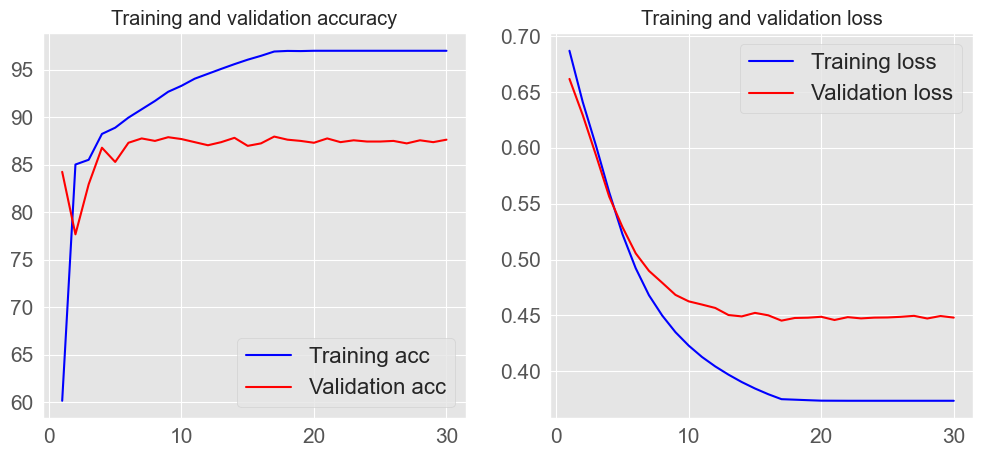

In [31]:
# cutoff = 15, patience = 1, factor = 0.1
cutoff = 15
patience = 1
factor = 0.1

dataset_tfidf, vocab_len = initialize_dataset_tfidf_vectorizer(args, cutoff)
classifier, loss_func, optimizer, scheduler = initialize_dense_classifier(args, vocab_len, loss_func, patience, factor)
trained_state = train_model(args, dataset_tfidf, classifier, optimizer, loss_func, scheduler)

plot_train_val_acc_loss(trained_state)

print("Vocabulary length: {:.3f}".format(vocab_len))

print("----------LOSS AND ACCURACY VALUES----------")
test(args, trained_state, classifier, dataset_tfidf, loss_func)
print("Test loss: {:.3f}".format(trained_state['test_loss']))
print("Test Accuracy: {:.2f}".format(trained_state['test_acc']))

Tweaking the `cutoff` parameter.

/var/folders/q5/49phy24d3m1bbh5t8j9nn9t40000gn/T/ipykernel_3464/3701461023.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Vocabulary length: 4546.000
----------LOSS AND ACCURACY VALUES----------
Test loss: 0.454
Test Accuracy: 85.16


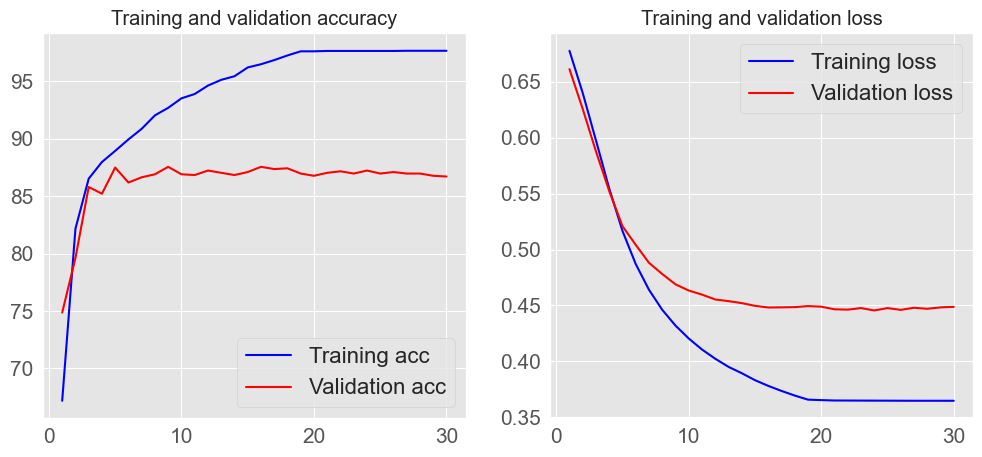

In [32]:
# cutoff = 15, patience = 1, factor = 0.1
cutoff = 15
patience = 1
factor = 0.1

dataset_tfidf, vocab_len = initialize_dataset_tfidf_vectorizer(args, cutoff)
classifier, loss_func, optimizer, scheduler = initialize_dense_classifier(args, vocab_len, loss_func, patience, factor)
trained_state = train_model(args, dataset_tfidf, classifier, optimizer, loss_func, scheduler)

plot_train_val_acc_loss(trained_state)

print("Vocabulary length: {:.3f}".format(vocab_len))

print("----------LOSS AND ACCURACY VALUES----------")
test(args, trained_state, classifier, dataset_tfidf, loss_func)
print("Test loss: {:.3f}".format(trained_state['test_loss']))
print("Test Accuracy: {:.2f}".format(trained_state['test_acc']))


/var/folders/q5/49phy24d3m1bbh5t8j9nn9t40000gn/T/ipykernel_3464/3701461023.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Vocabulary length: 5994.000
----------LOSS AND ACCURACY VALUES----------
Test loss: 0.453
Test Accuracy: 85.63


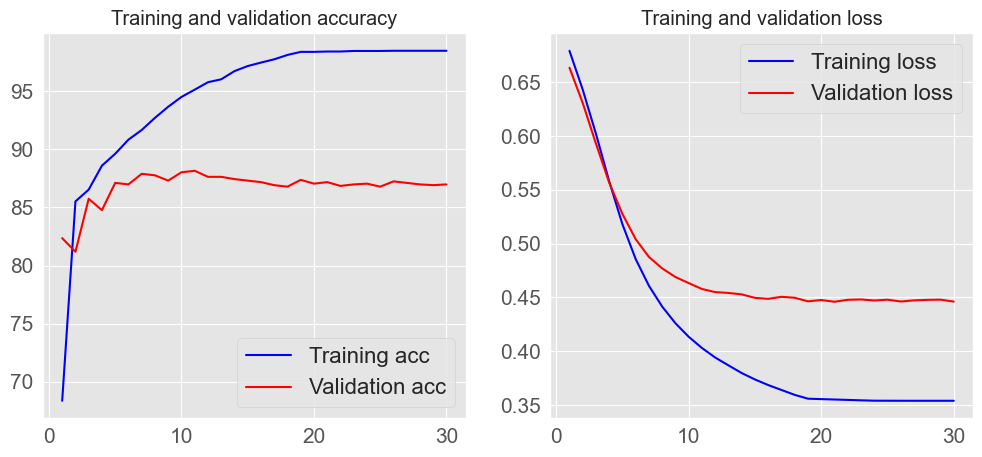

In [33]:
# cutoff = 10, patience = 1, factor = 0.1
cutoff = 10
patience = 1
factor = 0.1

dataset_tfidf, vocab_len = initialize_dataset_tfidf_vectorizer(args, cutoff)
classifier, loss_func, optimizer, scheduler = initialize_dense_classifier(args, vocab_len, loss_func, patience, factor)
trained_state = train_model(args, dataset_tfidf, classifier, optimizer, loss_func, scheduler)

plot_train_val_acc_loss(trained_state)

print("Vocabulary length: {:.3f}".format(vocab_len))

print("----------LOSS AND ACCURACY VALUES----------")
test(args, trained_state, classifier, dataset_tfidf, loss_func)
print("Test loss: {:.3f}".format(trained_state['test_loss']))
print("Test Accuracy: {:.2f}".format(trained_state['test_acc']))

In [ ]:
# cutoff = 5, patience = 1, factor = 0.1
cutoff = 5
patience = 1
factor = 0.1

dataset_tfidf, vocab_len = initialize_dataset_tfidf_vectorizer(args, cutoff)
classifier, loss_func, optimizer, scheduler = initialize_dense_classifier(args, vocab_len, loss_func, patience, factor)
trained_state = train_model(args, dataset_tfidf, classifier, optimizer, loss_func, scheduler)

print("Vocabulary length: {:.3f}".format(vocab_len))

print("----------LOSS AND ACCURACY VALUES----------")
test(args, trained_state, classifier, dataset_tfidf, loss_func)
print("Test loss: {:.3f}".format(trained_state['test_loss']))
print("Test Accuracy: {:.2f}".format(trained_state['test_acc']))

Vocabulary length: 9317.000
----------LOSS AND ACCURACY VALUES----------
Test loss: 0.339
Test Accuracy: 85.94


Tweaking `factor` parameter. `cutoff` is set to 10. The `args.learning_rate = 0.001`

----------LOSS AND ACCURACY VALUES----------
Test loss: 0.354
Test Accuracy: 85.47


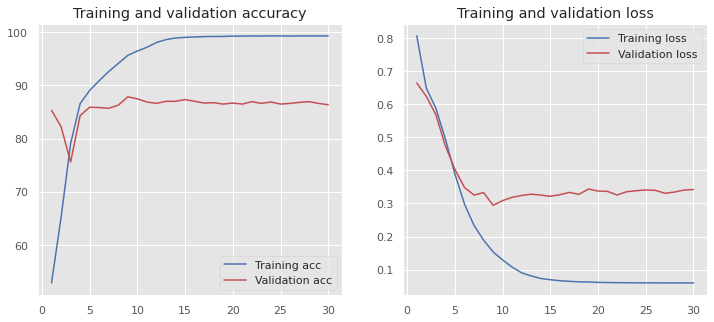

In [ ]:
# cutoff = 10, patience = 1, factor = 0.5
cutoff = 10
patience = 1
factor = 0.5

dataset_tfidf, vocab_len = initialize_dataset_tfidf_vectorizer(args, cutoff)
classifier, loss_func, optimizer, scheduler = initialize_dense_classifier(args, vocab_len, loss_func, patience, factor)
trained_state = train_model(args, dataset_tfidf, classifier, optimizer, loss_func, scheduler)

plot_train_val_acc_loss(trained_state)


print("----------LOSS AND ACCURACY VALUES----------")
test(args, trained_state, classifier, dataset_tfidf, loss_func)
print("Test loss: {:.3f}".format(trained_state['test_loss']))
print("Test Accuracy: {:.2f}".format(trained_state['test_acc']))

----------LOSS AND ACCURACY VALUES----------
Test loss: 0.335
Test Accuracy: 85.57


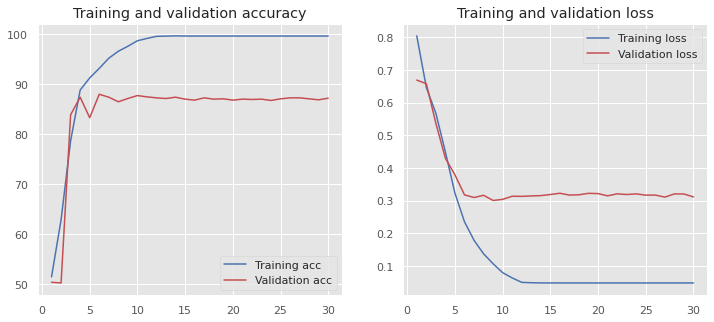

In [ ]:
# cutoff = 10, patience = 1, factor = 0.01
cutoff = 10
patience = 1
factor = 0.05

dataset_tfidf, vocab_len = initialize_dataset_tfidf_vectorizer(args, cutoff)
classifier, loss_func, optimizer, scheduler = initialize_dense_classifier(args, vocab_len, loss_func, patience, factor)
trained_state = train_model(args, dataset_tfidf, classifier, optimizer, loss_func, scheduler)

plot_train_val_acc_loss(trained_state)

print("----------LOSS AND ACCURACY VALUES----------")
test(args, trained_state, classifier, dataset_tfidf, loss_func)
print("Test loss: {:.3f}".format(trained_state['test_loss']))
print("Test Accuracy: {:.2f}".format(trained_state['test_acc']))

----------LOSS AND ACCURACY VALUES----------
Test loss: 0.334
Test Accuracy: 85.78


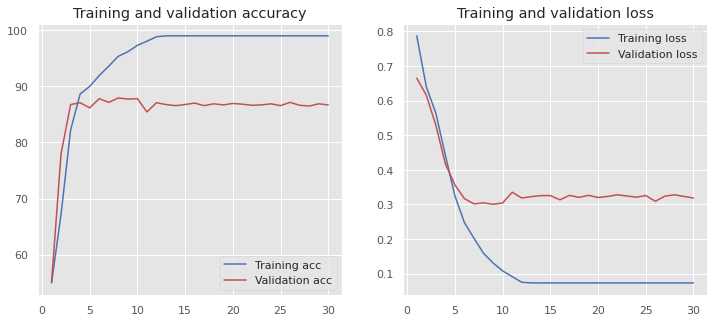

In [ ]:
# cutoff = 10, patience = 1, factor = 0.01
cutoff = 10
patience = 1
factor = 0.01

dataset_tfidf, vocab_len = initialize_dataset_tfidf_vectorizer(args, cutoff)
classifier, loss_func, optimizer, scheduler = initialize_dense_classifier(args, vocab_len, loss_func, patience, factor)
trained_state = train_model(args, dataset_tfidf, classifier, optimizer, loss_func, scheduler)

plot_train_val_acc_loss(trained_state)

print("----------LOSS AND ACCURACY VALUES----------")
test(args, trained_state, classifier, dataset_tfidf, loss_func)
print("Test loss: {:.3f}".format(trained_state['test_loss']))
print("Test Accuracy: {:.2f}".format(trained_state['test_acc']))

----------LOSS AND ACCURACY VALUES----------
Test loss: 0.335
Test Accuracy: 85.57


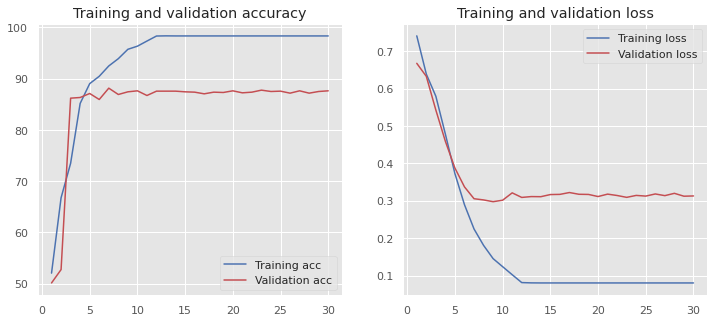

In [ ]:
# cutoff = 10, patience = 1, factor = 0.01
cutoff = 10
patience = 1
factor = 0.01

dataset_tfidf, vocab_len = initialize_dataset_tfidf_vectorizer(args, cutoff)
classifier, loss_func, optimizer, scheduler = initialize_dense_classifier(args, vocab_len, loss_func, patience, factor)
trained_state = train_model(args, dataset_tfidf, classifier, optimizer, loss_func, scheduler)

plot_train_val_acc_loss(trained_state)

print("----------LOSS AND ACCURACY VALUES----------")
test(args, trained_state, classifier, dataset_tfidf, loss_func)
print("Test loss: {:.3f}".format(trained_state['test_loss']))
print("Test Accuracy: {:.2f}".format(trained_state['test_acc']))

The best option for this parameters seems to be 0.01. The results over the `test` set are slightly better than the later ones related to the tweaking of this parameter.

Tweaking the `args.learning_rate` parameter. `factor` will take the value of 0.01 since it is the best amonst the later experiments. Mind that the later experiments have been executed with a learning rate of 0.001.

----------LOSS AND ACCURACY VALUES----------
Test loss: 0.504
Test Accuracy: 84.69


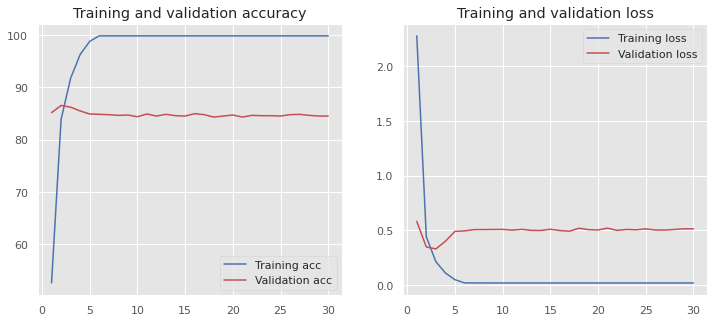

In [ ]:
# cutoff = 10, patience = 1, factor = 0.01, args.learning_rate = 0.01
cutoff = 10
patience = 1
factor = 0.01
args.learning_rate = 0.01

dataset_tfidf, vocab_len = initialize_dataset_tfidf_vectorizer(args, cutoff)
classifier, loss_func, optimizer, scheduler = initialize_dense_classifier(args, vocab_len, loss_func, patience, factor)
trained_state = train_model(args, dataset_tfidf, classifier, optimizer, loss_func, scheduler)

plot_train_val_acc_loss(trained_state)

print("----------LOSS AND ACCURACY VALUES----------")
test(args, trained_state, classifier, dataset_tfidf, loss_func)
print("Test loss: {:.3f}".format(trained_state['test_loss']))
print("Test Accuracy: {:.2f}".format(trained_state['test_acc']))

With a `learning_rate = 0.01`, the accuracy gets worse and the loss increases.

----------LOSS AND ACCURACY VALUES----------
Test loss: 0.574
Test Accuracy: 83.07


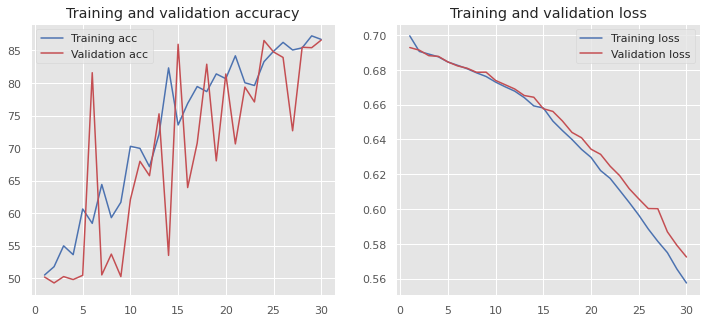

In [ ]:
# cutoff = 10, patience = 1, factor = 0.01, args.learning_rate = 0.01
cutoff = 10
patience = 1
factor = 0.01
args.learning_rate = 0.00005

dataset_tfidf, vocab_len = initialize_dataset_tfidf_vectorizer(args, cutoff)
classifier, loss_func, optimizer, scheduler = initialize_dense_classifier(args, vocab_len, loss_func, patience, factor)
trained_state = train_model(args, dataset_tfidf, classifier, optimizer, loss_func, scheduler)

plot_train_val_acc_loss(trained_state)

print("----------LOSS AND ACCURACY VALUES----------")
test(args, trained_state, classifier, dataset_tfidf, loss_func)
print("Test loss: {:.3f}".format(trained_state['test_loss']))
print("Test Accuracy: {:.2f}".format(trained_state['test_acc']))

With `learning_rate=0.00005` the results are very poor in comparison with the later ones.

----------LOSS AND ACCURACY VALUES----------
Test loss: 0.354
Test Accuracy: 85.57


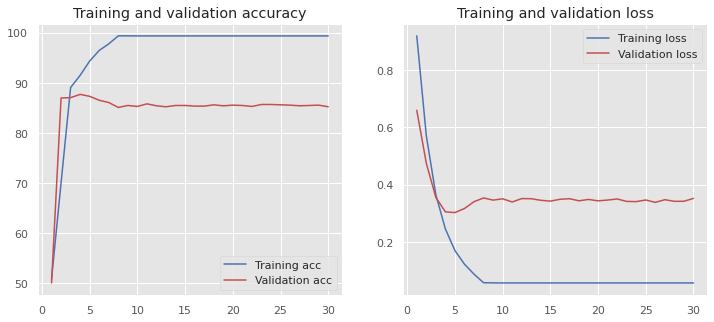

In [ ]:
# cutoff = 10, patience = 1, factor = 0.01, args.learning_rate = 0.01
cutoff = 10
patience = 1
factor = 0.01
args.learning_rate = 0.0025

dataset_tfidf, vocab_len = initialize_dataset_tfidf_vectorizer(args, cutoff)
classifier, loss_func, optimizer, scheduler = initialize_dense_classifier(args, vocab_len, loss_func, patience, factor)
trained_state = train_model(args, dataset_tfidf, classifier, optimizer, loss_func, scheduler)

plot_train_val_acc_loss(trained_state)

print("----------LOSS AND ACCURACY VALUES----------")
test(args, trained_state, classifier, dataset_tfidf, loss_func)
print("Test loss: {:.3f}".format(trained_state['test_loss']))
print("Test Accuracy: {:.2f}".format(trained_state['test_acc']))

Then, the best value for this parameter is the initial one. That is `args.learning_rate = 0.001`

For the later experiments we conclude that the best values for each of them are: <br>
* `cutoff=5`
* `factor=0.1`
* `learning_rate=0.001`

We train and evaluate the classifier with these values.

Vocabulary length: 9317.000
----------LOSS AND ACCURACY VALUES----------
Test loss: 0.317
Test Accuracy: 86.41


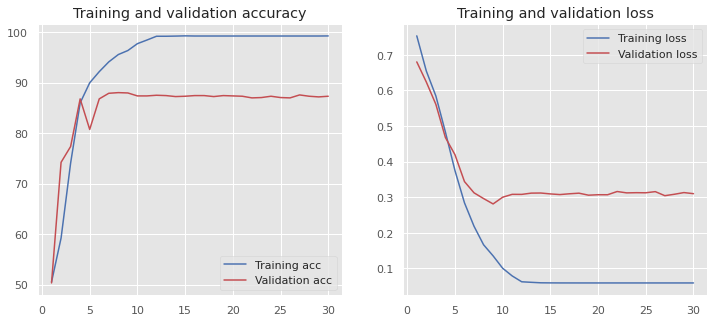

In [ ]:
# cutoff = 5, patience = 1, factor = 0.1
cutoff = 5
patience = 1
factor = 0.1
args.learning_rate=0.001

dataset_tfidf, vocab_len = initialize_dataset_tfidf_vectorizer(args, cutoff)
classifier, loss_func, optimizer, scheduler = initialize_dense_classifier(args, vocab_len, loss_func, patience, factor)
trained_state = train_model(args, dataset_tfidf, classifier, optimizer, loss_func, scheduler)

plot_train_val_acc_loss(trained_state)

print("Vocabulary length: {:.3f}".format(vocab_len))

print("----------LOSS AND ACCURACY VALUES----------")
test(args, trained_state, classifier, dataset_tfidf, loss_func)
print("Test loss: {:.3f}".format(trained_state['test_loss']))
print("Test Accuracy: {:.2f}".format(trained_state['test_acc']))

The experiments of the convolutional model architecture will be executed with these values of factor and learning rate.

## Experiments with convolutional model architecture.

The experiments of the proposed architecture for the word embedding representation consisted in tweaking the number of channels and the kernel size of the convolutional layer, that is `out_channels` and `kernel_size` parameters. The parameters related to the first architectural proposal remains the same, that is `epochs`, `batch_size`, `learning_rate` and `factor`.



First, we instantiate the dataset and the vectorizer in order to initialize the word embedding matrix filtered by the vocabulary computed against the training set. Mind again that it is important to use a GPU in order to accelerate the training step.

In [ ]:
if not torch.cuda.is_available():
  print("Cuda not available")
  args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")

# dataset and vectorizer
args.vectorizer_type = vectorizers.embedder
torch_emb_dataset = FilmReviewDataset.load_dataset_and_build_word_embedder(dataset_splitted,
                                                                           args.path_embeddings)


review_vectorizer = torch_emb_dataset.get_vectorizer()

embedding_matrix = review_vectorizer.vectorizer.get_embedding_matrix()

Next we instantiate the classifier. It will be instantiated the `classifier`, `loss_func`, `optimizer` and `scheduler`. For each trained model, it will be plotted its plots of loss and accuracies and the loss/accuracy over the `test` set. <br>
The loss function is the same as the used for the first model approach (`BCEWithLogitsLoss`).

In [ ]:
def initialize_embedding_classifier(out_channels, kernel_size, loss):
  classifier = ReviewClassifierEmbedding(num_features=args.embedding_size, pretrained_matrix=torch.FloatTensor(embedding_matrix),
                                       out_channels = out_channels, kernel_size=kernel_size)
  classifier.to(args.device)
  loss_func = loss
  optimizer = torch.optim.Adam(classifier.parameters(), lr=args.learning_rate)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.1,
                                                 patience=1)
  return classifier, loss_func, optimizer, scheduler

In [ ]:
binary_loss = nn.BCEWithLogitsLoss()


----------LOSS AND ACCURACY VALUES----------
(0.5099164783954622, 77.18749999999999)


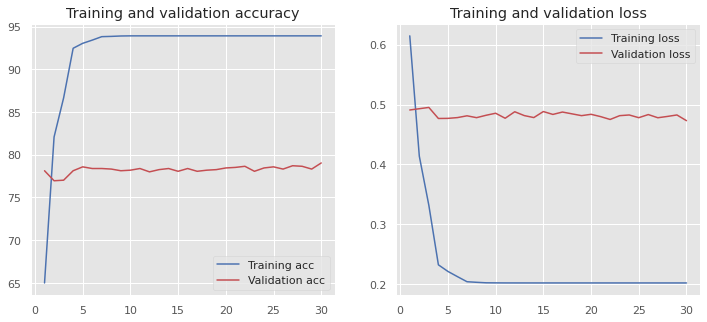

In [ ]:
# out_channels = 10, kernel_size = 8
out_channels = 10
kernel_size = 8
classifier_10_8, loss_func, optimizer, scheduler = initialize_embedding_classifier(out_channels, kernel_size, binary_loss)
trained_10_8_state = train_model(args, torch_emb_dataset, classifier_10_8, optimizer, loss_func, scheduler)
plot_train_val_acc_loss(trained_10_8_state)
print("----------LOSS AND ACCURACY VALUES----------")
print(test(args, trained_10_8_state, classifier_10_8, torch_emb_dataset, loss_func))

----------LOSS AND ACCURACY VALUES----------
(0.5293515602747599, 76.82291666666667)


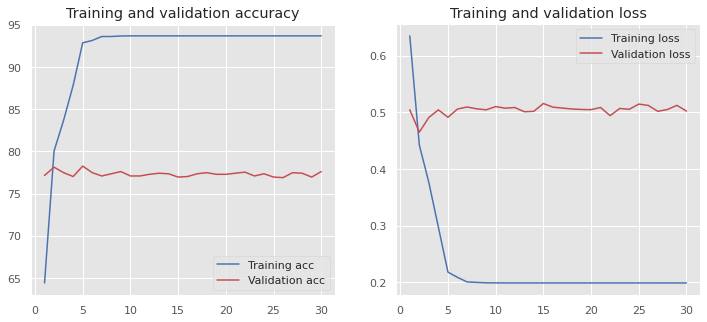

In [ ]:
# out_channels = 9, kernel_size = 8
out_channels = 9
kernel_size = 8
classifier_9_8, loss_func, optimizer, scheduler = initialize_embedding_classifier(out_channels, kernel_size, binary_loss)
trained_9_8_state = train_model(args, torch_emb_dataset, classifier_9_8, optimizer, loss_func, scheduler)
plot_train_val_acc_loss(trained_9_8_state)
print("----------LOSS AND ACCURACY VALUES----------")
print(test(args, trained_9_8_state, classifier_9_8, torch_emb_dataset, loss_func))

It seems that varying the `out_channel` variable the curve does not change so much. We observe that the accuracy and loss are worse in this last case over the `test` set.
Now, it will be tweaked the `kernel_size` parameter.

----------LOSS AND ACCURACY VALUES----------
(0.5393398622671763, 76.19791666666666)


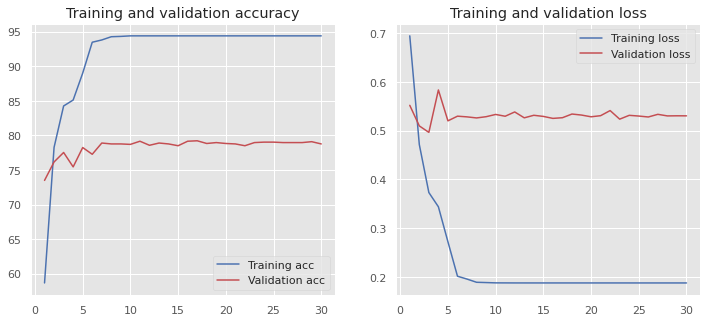

In [ ]:
# out_channels = 9, kernel_size = 5
out_channels = 9
kernel_size = 5
classifier_9_5, loss_func, optimizer, scheduler = initialize_embedding_classifier(out_channels, kernel_size, binary_loss)
trained_9_5_state = train_model(args, torch_emb_dataset, classifier_9_5, optimizer, loss_func, scheduler)
plot_train_val_acc_loss(trained_9_5_state)
print("----------LOSS AND ACCURACY VALUES----------")
print(test(args, trained_9_5_state, classifier_9_5, torch_emb_dataset, loss_func))

----------LOSS AND ACCURACY VALUES----------
(0.5520678063233694, 75.78125)


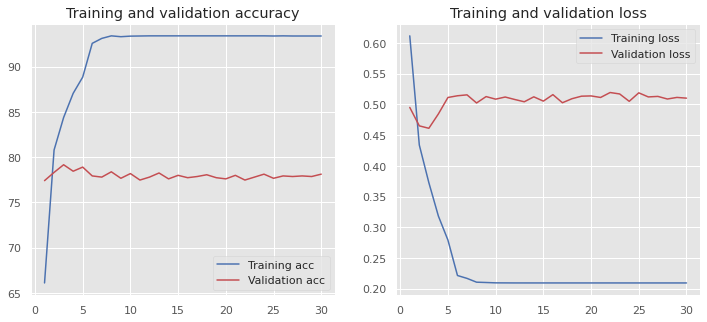

In [ ]:
# out_channels = 9, kernel_size = 3
out_channels = 9
kernel_size = 3
classifier_9_3, loss_func, optimizer, scheduler = initialize_embedding_classifier(out_channels, kernel_size, binary_loss)
trained_9_3_state = train_model(args, torch_emb_dataset, classifier_9_3, optimizer, loss_func, scheduler)
plot_train_val_acc_loss(trained_9_3_state)
print("----------LOSS AND ACCURACY VALUES----------")
print(test(args, trained_9_3_state, classifier_9_3, torch_emb_dataset, loss_func))

----------LOSS AND ACCURACY VALUES----------
(0.4937103072802226, 77.55208333333333)


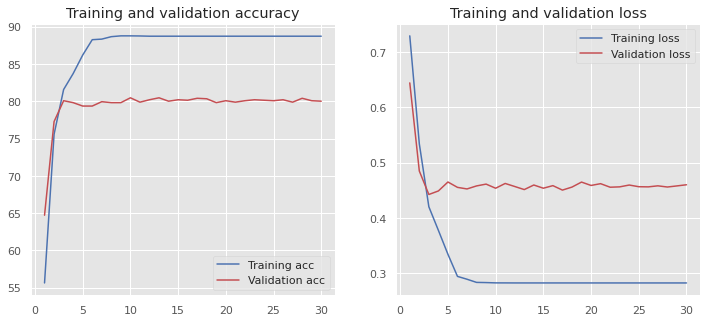

In [ ]:
# out_channels = 9, kernel_size = 1
out_channels = 9
kernel_size = 1
classifier_9_1, loss_func, optimizer, scheduler = initialize_embedding_classifier(out_channels, kernel_size, binary_loss)
trained_9_1_state = train_model(args, torch_emb_dataset, classifier_9_1, optimizer, loss_func, scheduler)
plot_train_val_acc_loss(trained_9_1_state)
print("----------LOSS AND ACCURACY VALUES----------")
print(test(args, trained_9_1_state, classifier_9_1, torch_emb_dataset, loss_func))

For a `kernel_size = 1` we sightly avoid the latent overfitting of the two first plots. Indeed, the accuracy over the test set is the better compared with the later experiments. <br>

Lastly, let's try an edge case. For example, `out_channels = 3` and `kernel_size = 1`.

----------LOSS AND ACCURACY VALUES----------
(0.45652286410331727, 80.36458333333334)


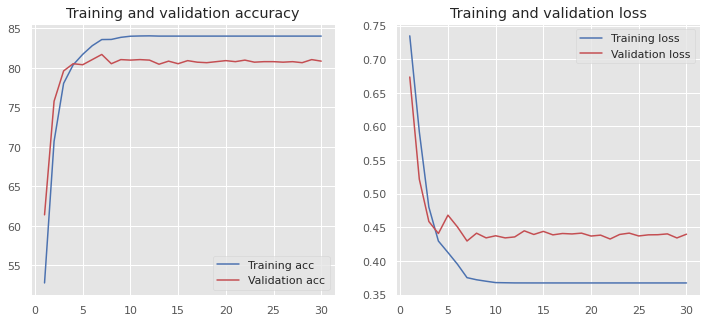

In [ ]:
# out_channels = 3, kernel_size = 1
out_channels = 3
kernel_size = 1
classifier_3_1, loss_func, optimizer, scheduler = initialize_embedding_classifier(out_channels, kernel_size, binary_loss)
trained_3_1_state = train_model(args, torch_emb_dataset, classifier_3_1, optimizer, loss_func, scheduler)
plot_train_val_acc_loss(trained_3_1_state)
print("----------LOSS AND ACCURACY VALUES----------")
print(test(args, trained_3_1_state, classifier_3_1, torch_emb_dataset, loss_func))

The accuracy and loss in this last experiment still remains the same over the validation set although the train accuracy is worse that the ones obtained in the later experiments.

The results indicate that our model has not overfitted during the training. However, the accuracy is not greater than the ones obtained with a `SVM` approach. Possible reasons of this may be:



*   The layers proposed are not good enough to fit the nuances of the dataset
*   The word embedding review representation does not contain the information needed to obtain better results when classifying new reviews.
*   The values of the hyperparameters are not properly optimized.

# 5. Conclusions

Summing up all the results obtained from the trained models we have: <br>

* SVM with TF-IDF yields good results of accuracy with RBF as a kernel function. Exactly an accuracy of 0.86.
* K-nn does not return good results since it is an algorithm that do not work properly with vectors in high dimensional spaces (it suffers from the curse of dimensionality). The results of accuracy are the worst.
* With the dense neural network architecture and TF-IDF as a document representation, the best result is obtained with a `cutoff=5`, `factor=0.1` and `learning_rate=0.001` yielding an accuracy and loss over the `test` set of 0.8641 and 0.317 respectively. The results are slightly better than the ones obtained with the SVM and TF-IDF approach.
* With the convolutional neural network with the word embedding representation the results are worse in comparison to the dense neural network approach. It is possible that the word embedding representantion does not fit properly when representing the semantic information of a word within this task. However, we get an accuracy and loss of 0.8036 and 0.45 respectively with `out_channels = 3` and `kernel_size=1`.

It is interesting to highlight the timings related to the training process. Training the SVM and looking for the best model with the grid search approach took a little bit longer compared to the neural network approach. However, these last ones are faster due to the use of the CUDA environment.